# Boston Marathon Performance Analysis

This notebook help us to analysis a marathon using boston marathon dataset

# Import Libraries and Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer, LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, VotingRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.inspection import permutation_importance
from scipy import stats
from scipy.stats import jarque_bera, shapiro, normaltest
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
np.random.seed(42)

# Data Loading and Initial Exploration

In [ ]:
url = "/content/Athletes.csv"
df = pd.read_csv(url)

print(f"Dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("\nColumn types:")
print(df.dtypes)
print("\nMissing values:")
print(df.isnull().sum())
print("\nBasic statistics:")
print(df.describe())

Dataset shape: (17220, 10)
Memory usage: 3.04 MB

Column types:
Bib                 int64
Zip                 int64
Age                 int64
Age Group          object
Gender             object
First Half          int64
Second Half         int64
Finish              int64
Positive Split      int64
Percent Change    float64
dtype: object

Missing values:
Bib               0
Zip               0
Age               0
Age Group         0
Gender            0
First Half        0
Second Half       0
Finish            0
Positive Split    0
Percent Change    0
dtype: int64

Basic statistics:
                Bib           Zip           Age    First Half   Second Half  \
count  17220.000000  17220.000000  17220.000000  17220.000000  17220.000000   
mean   15688.916783  38541.031127     42.217828   6526.240999   7587.674158   
std     8827.226766  34262.257821     12.540766   1270.014789   1779.232288   
min        9.000000    627.000000     18.000000   3795.000000   3961.000000   
25%     7997.75000

# Data Cleaning and Preprocessing

In [ ]:
df['time'] = df['First Half'] + df['Second Half']
display(df[['First Half', 'Second Half', 'time']].head())
df['Time_seconds'] = df['Finish']
df = df.dropna(subset=['Time_seconds'])

df['Age_group'] = pd.cut(df['Age'], bins=[0, 30, 40, 50, 60, 100], labels=['<30', '30-40', '40-50', '50-60', '60+'])
df['Pace_per_mile'] = df['Time_seconds'] / 26.2
df['Speed_mph'] = 26.2 / (df['Time_seconds'] / 3600)

df['Performance_category'] = pd.cut(df['Time_seconds'],
                                   bins=[0, 10800, 12600, 14400, 16200, np.inf],
                                   labels=['Elite', 'Sub3', 'Sub3.5', 'Sub4', 'Recreational'])

Q1 = df['Time_seconds'].quantile(0.25)
Q3 = df['Time_seconds'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df = df[(df['Time_seconds'] >= lower_bound) & (df['Time_seconds'] <= upper_bound)]

print(f"Cleaned dataset shape: {df.shape}")

,First Half,Second Half,time
0,3832,3961,7793
1,3845,4059,7904
2,3795,4157,7952
3,3997,4065,8062
4,3979,4198,8177


Cleaned dataset shape: (17156, 16)


# Advanced Feature Engineering

In [ ]:
df_encoded = df.copy()

le_gender = LabelEncoder()
le_country = LabelEncoder()
le_city = LabelEncoder()

df_encoded['Gender_encoded'] = le_gender.fit_transform(df_encoded['Gender'])
df_encoded['Country_encoded'] = le_country.fit_transform(df_encoded['Zip'])
df_encoded['City_encoded'] = le_city.fit_transform(df_encoded['Zip'])

df_encoded['Age_Gender_interaction'] = df_encoded['Age'] * df_encoded['Gender_encoded']
df_encoded['Age_squared'] = df_encoded['Age'] ** 2
df_encoded['Age_cubed'] = df_encoded['Age'] ** 3

df_encoded['Age_bin'] = pd.cut(df_encoded['Age'], bins=10, labels=False)

median_time = df_encoded['Time_seconds'].median()
df_encoded['Time_ratio_to_median'] = df_encoded['Time_seconds'] / median_time

df_encoded['Fast_runner'] = (df_encoded['Time_seconds'] < df_encoded['Time_seconds'].quantile(0.3)).astype(int)

print("Advanced features created successfully")
print(f"Final feature count: {df_encoded.shape[1]}")

Advanced features created successfully
Final feature count: 25


# Comprehensive Statistical Analysis

In [ ]:
numeric_cols = df_encoded.select_dtypes(include=[np.number]).columns

normality_results = {}
for col in ['Time_seconds', 'Age', 'Speed_mph']:
    if col in df_encoded.columns:
        stat_jb, p_jb = jarque_bera(df_encoded[col].dropna())
        stat_sw, p_sw = shapiro(df_encoded[col].dropna().sample(min(5000, len(df_encoded))))
        normality_results[col] = {'jarque_bera_p': p_jb, 'shapiro_p': p_sw}

print("Normality test results (p-values):")
for col, results in normality_results.items():
    print(f"{col}: JB={results['jarque_bera_p']:.6f}, SW={results['shapiro_p']:.6f}")

correlation_matrix = df_encoded[numeric_cols].corr()
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], corr_val))

print(f"\nHigh correlation pairs (>0.7): {len(high_corr_pairs)}")

Normality test results (p-values):
Time_seconds: JB=0.000000, SW=0.000000
Age: JB=0.000000, SW=0.000000
Speed_mph: JB=0.000000, SW=0.000000

High correlation pairs (>0.7): 49


# Comprehensive Data Visualization Dashboard

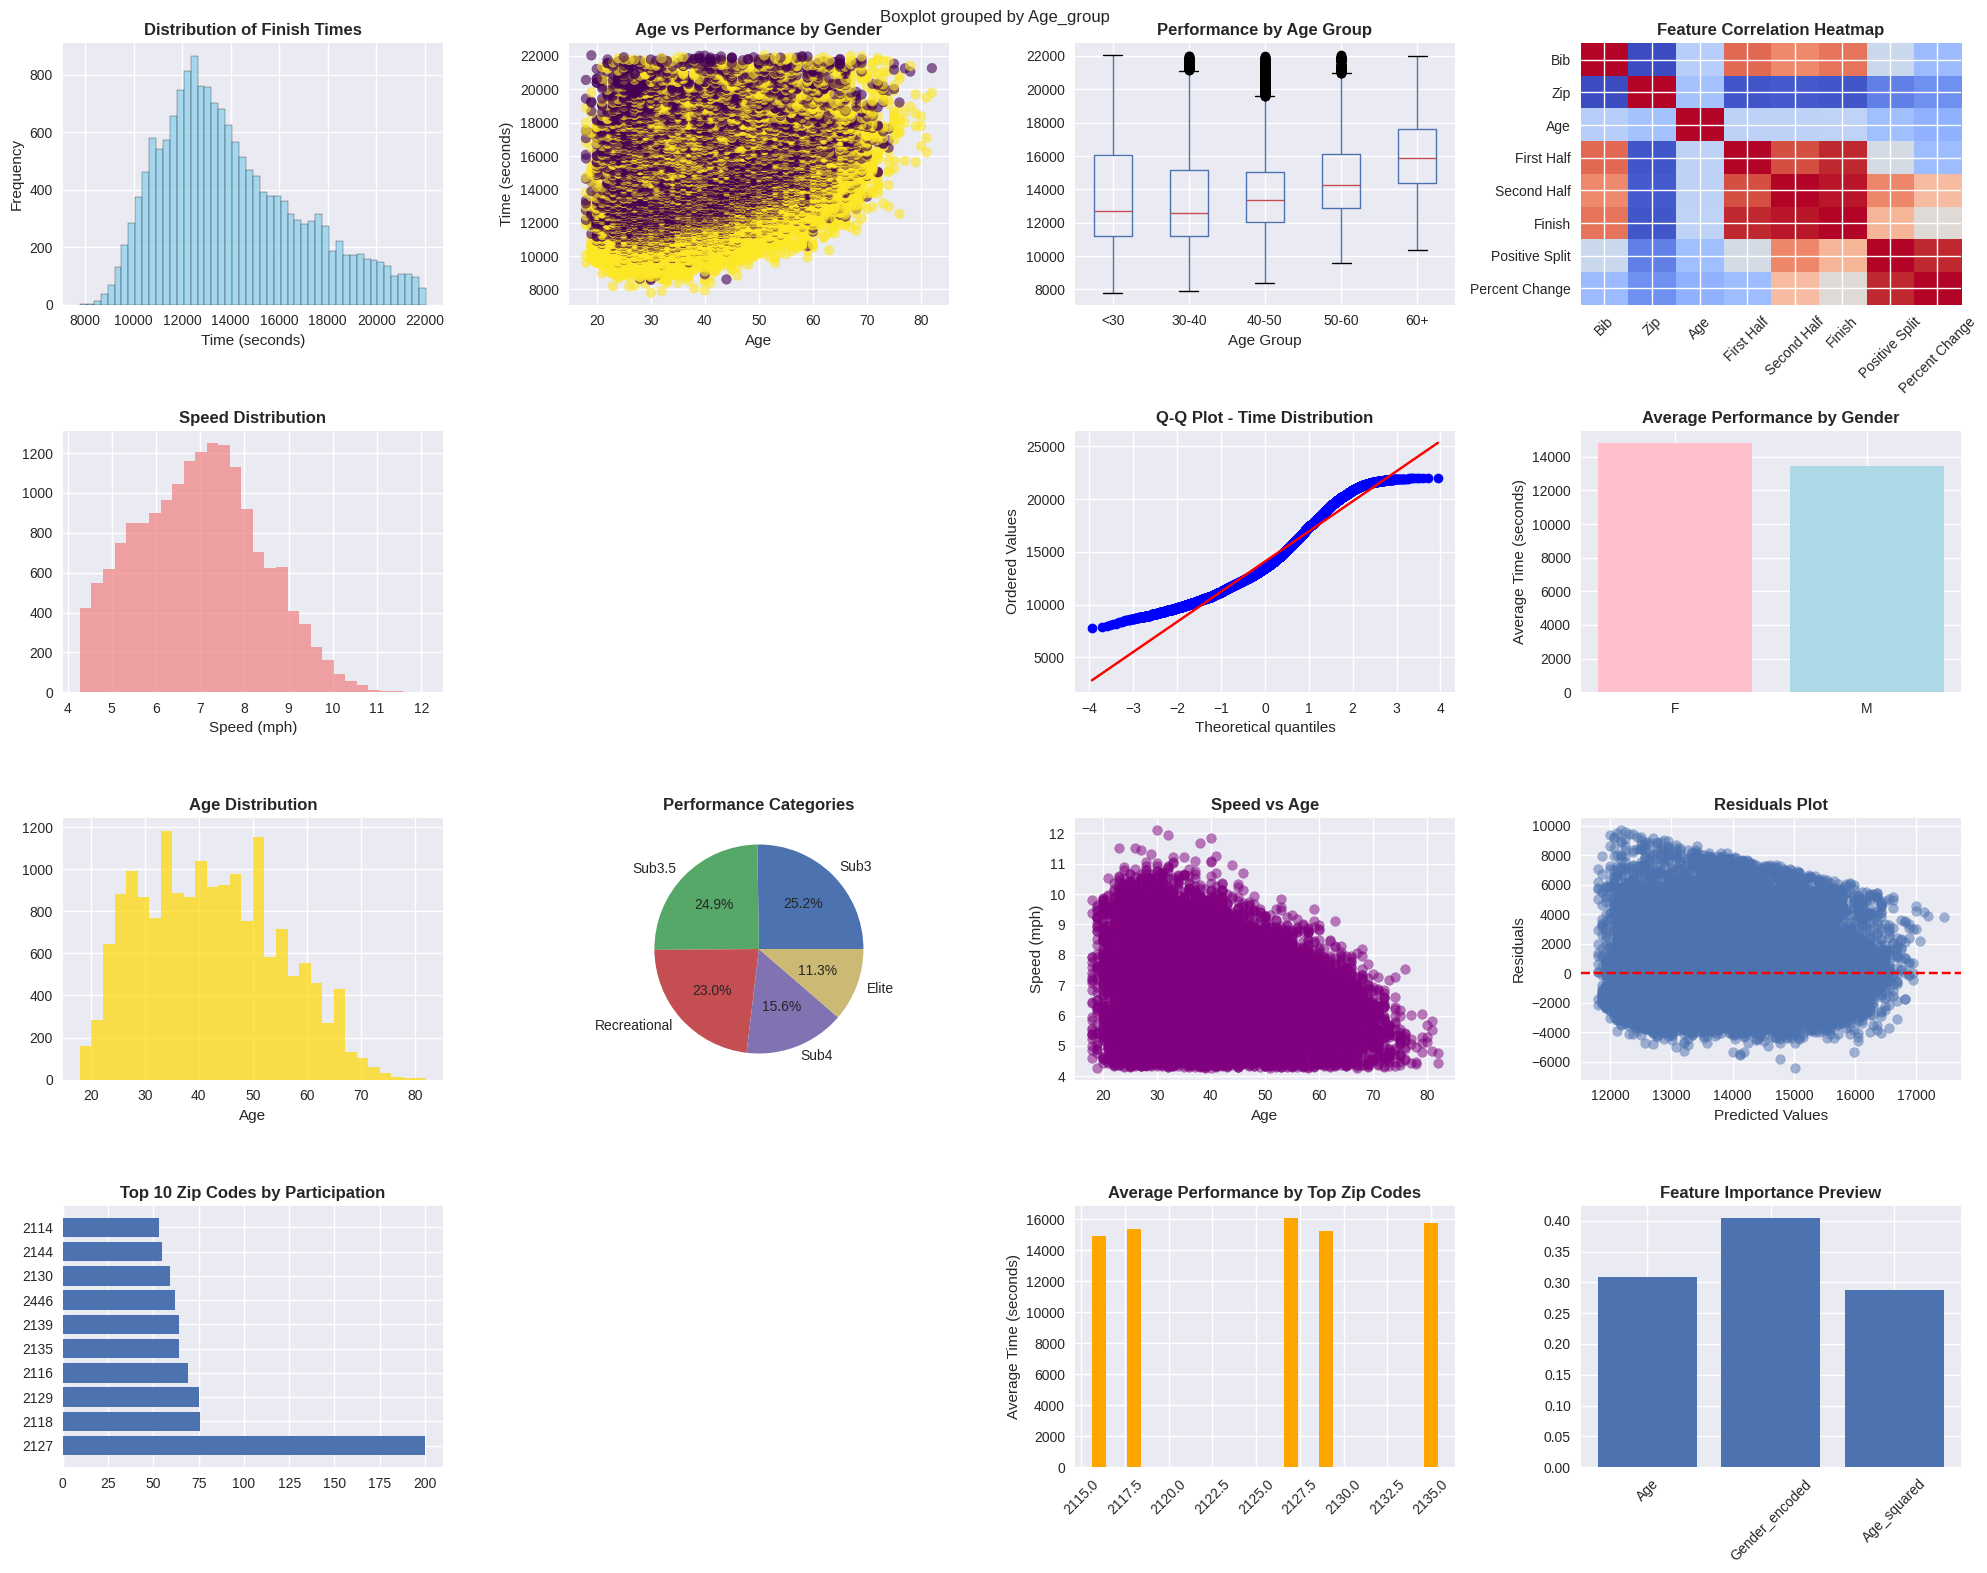

In [ ]:
fig, axes = plt.subplots(4, 4, figsize=(20, 16))
fig.suptitle('Boston Marathon Analysis Dashboard', fontsize=20, fontweight='bold')

axes[0,0].hist(df_encoded['Time_seconds'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Distribution of Finish Times', fontweight='bold')
axes[0,0].set_xlabel('Time (seconds)')
axes[0,0].set_ylabel('Frequency')

scatter = axes[0,1].scatter(df_encoded['Age'], df_encoded['Time_seconds'],
                           c=df_encoded['Gender_encoded'], alpha=0.6, cmap='viridis')
axes[0,1].set_title('Age vs Performance by Gender', fontweight='bold')
axes[0,1].set_xlabel('Age')
axes[0,1].set_ylabel('Time (seconds)')

df_encoded.boxplot(column='Time_seconds', by='Age_group', ax=axes[0,2])
axes[0,2].set_title('Performance by Age Group', fontweight='bold')
axes[0,2].set_xlabel('Age Group')

im = axes[0,3].imshow(correlation_matrix.iloc[:8, :8], cmap='coolwarm', aspect='auto')
axes[0,3].set_title('Feature Correlation Heatmap', fontweight='bold')
axes[0,3].set_xticks(range(8))
axes[0,3].set_yticks(range(8))
axes[0,3].set_xticklabels(correlation_matrix.columns[:8], rotation=45)
axes[0,3].set_yticklabels(correlation_matrix.columns[:8])

axes[1,0].hist(df_encoded['Speed_mph'], bins=30, alpha=0.7, color='lightcoral')
axes[1,0].set_title('Speed Distribution', fontweight='bold')
axes[1,0].set_xlabel('Speed (mph)')

axes[1,1].set_visible(False)
stats.probplot(df_encoded['Time_seconds'], dist="norm", plot=axes[1,2])
axes[1,2].set_title('Q-Q Plot - Time Distribution', fontweight='bold')

gender_perf = df_encoded.groupby('Gender')['Time_seconds'].mean()
axes[1,3].bar(gender_perf.index, gender_perf.values, color=['pink', 'lightblue'])
axes[1,3].set_title('Average Performance by Gender', fontweight='bold')
axes[1,3].set_ylabel('Average Time (seconds)')

axes[2,0].hist(df_encoded['Age'], bins=30, alpha=0.7, color='gold')
axes[2,0].set_title('Age Distribution', fontweight='bold')
axes[2,0].set_xlabel('Age')

perf_counts = df_encoded['Performance_category'].value_counts()
axes[2,1].pie(perf_counts.values, labels=perf_counts.index, autopct='%1.1f%%')
axes[2,1].set_title('Performance Categories', fontweight='bold')

axes[2,2].scatter(df_encoded['Age'], df_encoded['Speed_mph'], alpha=0.5, c='purple')
axes[2,2].set_title('Speed vs Age', fontweight='bold')
axes[2,2].set_xlabel('Age')
axes[2,2].set_ylabel('Speed (mph)')

X_simple = df_encoded[['Age', 'Gender_encoded']].dropna()
y_simple = df_encoded.loc[X_simple.index, 'Time_seconds']
lr_simple = LinearRegression().fit(X_simple, y_simple)
residuals = y_simple - lr_simple.predict(X_simple)
axes[2,3].scatter(lr_simple.predict(X_simple), residuals, alpha=0.5)
axes[2,3].axhline(y=0, color='red', linestyle='--')
axes[2,3].set_title('Residuals Plot', fontweight='bold')
axes[2,3].set_xlabel('Predicted Values')
axes[2,3].set_ylabel('Residuals')

top_zips = df_encoded['Zip'].value_counts().head(10)
axes[3,0].barh(range(len(top_zips)), top_zips.values)
axes[3,0].set_yticks(range(len(top_zips)))
axes[3,0].set_yticklabels(top_zips.index)
axes[3,0].set_title('Top 10 Zip Codes by Participation', fontweight='bold')

axes[3,1].set_visible(False)

top5_zips = df_encoded['Zip'].value_counts().head(5).index
zip_perf = df_encoded[df_encoded['Zip'].isin(top5_zips)].groupby('Zip')['Time_seconds'].mean()
axes[3,2].bar(zip_perf.index, zip_perf.values, color='orange')
axes[3,2].set_title('Average Performance by Top Zip Codes', fontweight='bold')
axes[3,2].set_ylabel('Average Time (seconds)')
axes[3,2].tick_params(axis='x', rotation=45)

feature_cols = ['Age', 'Gender_encoded', 'Age_squared']
X_preview = df_encoded[feature_cols].dropna()
y_preview = df_encoded.loc[X_preview.index, 'Time_seconds']
rf_preview = RandomForestRegressor(n_estimators=50, random_state=42)
rf_preview.fit(X_preview, y_preview)
axes[3,3].bar(feature_cols, rf_preview.feature_importances_)
axes[3,3].set_title('Feature Importance Preview', fontweight='bold')
axes[3,3].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Data Preparation for Machine Learning

In [ ]:
feature_columns = ['Age', 'Gender_encoded', 'Country_encoded', 'City_encoded',
                  'Age_Gender_interaction', 'Age_squared', 'Age_cubed', 'Age_bin']

available_features = [col for col in feature_columns if col in df_encoded.columns]
X = df_encoded[available_features].copy()
y = df_encoded['Time_seconds'].copy()

mask = ~(X.isnull().any(axis=1) | y.isnull())
X = X[mask]
y = y[mask]

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X[['Age', 'Gender_encoded']])
poly_feature_names = poly.get_feature_names_out(['Age', 'Gender_encoded'])

X_combined = np.hstack([X.values, X_poly])
all_feature_names = available_features + list(poly_feature_names)

print(f"Final dataset shape: {X_combined.shape}")
print(f"Target variable shape: {y.shape}")
print(f"Total features: {len(all_feature_names)}")

Final dataset shape: (17156, 11)
Target variable shape: (17156,)
Total features: 11


# Multiple Preprocessing Pipelines

In [ ]:
preprocessing_strategies = {
    'standard': StandardScaler(),
    'minmax': MinMaxScaler(),
    'robust': RobustScaler(),
    'power': PowerTransformer(method='yeo-johnson'),
    'quantile': QuantileTransformer(output_distribution='normal')
}

X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=42)

X_train_processed = {}
X_test_processed = {}

for name, scaler in preprocessing_strategies.items():
    X_train_processed[name] = scaler.fit_transform(X_train)
    X_test_processed[name] = scaler.transform(X_test)
    print(f"Applied {name} preprocessing")

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Applied standard preprocessing
Applied minmax preprocessing
Applied robust preprocessing
Applied power preprocessing
Applied quantile preprocessing
Training set shape: (13724, 11)
Test set shape: (3432, 11)


# Model Definitions and Hyperparameter Grids

In [ ]:
models_and_params = {
    'linear_regression': {
        'model': LinearRegression(),
        'params': {}
    },
    'ridge': {
        'model': Ridge(),
        'params': {
            'alpha': [0.1, 1.0, 10.0, 100.0, 1000.0],
            'solver': ['auto', 'svd', 'cholesky', 'lsqr']
        }
    },
    'lasso': {
        'model': Lasso(),
        'params': {
            'alpha': [0.1, 1.0, 10.0, 100.0],
            'max_iter': [1000, 2000, 5000]
        }
    },
    'elastic_net': {
        'model': ElasticNet(),
        'params': {
            'alpha': [0.1, 1.0, 10.0],
            'l1_ratio': [0.1, 0.5, 0.7, 0.9],
            'max_iter': [1000, 2000]
        }
    },
    'decision_tree': {
        'model': DecisionTreeRegressor(),
        'params': {
            'max_depth': [3, 5, 7, 10, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'criterion': ['squared_error', 'absolute_error']
        }
    },
    'random_forest': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 7, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2', None]
        }
    },
    'gradient_boosting': {
        'model': GradientBoostingRegressor(),
        'params': {
            'n_estimators': [50, 100, 150],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 0.9, 1.0]
        }
    },
    'ada_boost': {
        'model': AdaBoostRegressor(),
        'params': {
            'n_estimators': [50, 100, 150],
            'learning_rate': [0.01, 0.1, 1.0],
            'loss': ['linear', 'square', 'exponential']
        }
    },
    'svr': {
        'model': SVR(),
        'params': {
            'kernel': ['linear', 'rbf', 'poly'],
            'C': [0.1, 1, 10, 100],
            'gamma': ['scale', 'auto', 0.001, 0.01]
        }
    },
    'knn': {
        'model': KNeighborsRegressor(),
        'params': {
            'n_neighbors': [3, 5, 7, 11, 15],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree']
        }
    },
    'mlp': {
        'model': MLPRegressor(max_iter=1000),
        'params': {
            'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
            'activation': ['relu', 'tanh'],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate': ['constant', 'adaptive']
        }
    }
}

print(f"Total models to train: {len(models_and_params)}")

Total models to train: 11


# Model Training and Hyperparameter Optimization

In [ ]:
model_results = {}
best_models = {}

best_preprocessing = 'robust'
X_train_best = X_train_processed[best_preprocessing]
X_test_best = X_test_processed[best_preprocessing]

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Starting comprehensive model training and optimization...")
print("=" * 60)

for model_name, model_config in models_and_params.items():
    print(f"\nTraining {model_name.upper()}...")

    model = model_config['model']
    param_grid = model_config['params']

    if param_grid:
        random_search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_grid,
            n_iter=20,
            cv=5,
            scoring='neg_mean_squared_error',
            n_jobs=-1,
            random_state=42,
            verbose=0
        )

        try:
            random_search.fit(X_train_best, y_train)
            best_model = random_search.best_estimator_
            best_params = random_search.best_params_
            cv_score = -random_search.best_score_

        except Exception as e:
            print(f"Error in hyperparameter optimization for {model_name}: {e}")
            model.fit(X_train_best, y_train)
            best_model = model
            best_params = {}
            cv_scores = cross_val_score(model, X_train_best, y_train,
                                      cv=5, scoring='neg_mean_squared_error')
            cv_score = -cv_scores.mean()
    else:
        try:
            model.fit(X_train_best, y_train)
            best_model = model
            best_params = {}
            cv_scores = cross_val_score(model, X_train_best, y_train,
                                      cv=5, scoring='neg_mean_squared_error')
            cv_score = -cv_scores.mean()
        except Exception as e:
            print(f"Error training {model_name}: {e}")
            continue

    try:
        y_pred_train = best_model.predict(X_train_best)
        y_pred_test = best_model.predict(X_test_best)

        train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
        train_r2 = r2_score(y_train, y_pred_train)
        test_r2 = r2_score(y_test, y_pred_test)
        train_mae = mean_absolute_error(y_train, y_pred_train)
        test_mae = mean_absolute_error(y_test, y_pred_test)

        def safe_mape(y_true, y_pred):
            mask = y_true != 0
            return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

        train_mape = safe_mape(y_train, y_pred_train)
        test_mape = safe_mape(y_test, y_pred_test)

        model_results[model_name] = {
            'model': best_model,
            'best_params': best_params,
            'cv_rmse': np.sqrt(cv_score),
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'train_mae': train_mae,
            'test_mae': test_mae,
            'train_mape': train_mape,
            'test_mape': test_mape,
            'y_pred_train': y_pred_train,
            'y_pred_test': y_pred_test
        }

        best_models[model_name] = best_model

        print(f"✓ {model_name}: CV RMSE = {np.sqrt(cv_score):.2f}, "
              f"Test RMSE = {test_rmse:.2f}, Test R² = {test_r2:.4f}")

    except Exception as e:
        print(f"Error in prediction for {model_name}: {e}")
        continue

print("\n" + "=" * 60)
print("Model training completed!")
print(f"Successfully trained {len(model_results)} models")

Starting comprehensive model training and optimization...

Training LINEAR_REGRESSION...
✓ linear_regression: CV RMSE = 2555.51, Test RMSE = 2535.95, Test R² = 0.2376

Training RIDGE...
✓ ridge: CV RMSE = 2555.48, Test RMSE = 2535.88, Test R² = 0.2377

Training LASSO...
✓ lasso: CV RMSE = 2555.54, Test RMSE = 2535.77, Test R² = 0.2377

Training ELASTIC_NET...
✓ elastic_net: CV RMSE = 2557.62, Test RMSE = 2537.44, Test R² = 0.2367

Training DECISION_TREE...
✓ decision_tree: CV RMSE = 2459.51, Test RMSE = 2444.82, Test R² = 0.2914

Training RANDOM_FOREST...
✓ random_forest: CV RMSE = 2431.16, Test RMSE = 2410.30, Test R² = 0.3113

Training GRADIENT_BOOSTING...
✓ gradient_boosting: CV RMSE = 2413.80, Test RMSE = 2409.74, Test R² = 0.3116

Training ADA_BOOST...
✓ ada_boost: CV RMSE = 2509.67, Test RMSE = 2489.09, Test R² = 0.2655

Training SVR...
✓ svr: CV RMSE = 2530.52, Test RMSE = 2507.32, Test R² = 0.2547

Training KNN...
✓ knn: CV RMSE = 2502.71, Test RMSE = 2484.52, Test R² = 0.2682


# Create results summary DataFrame

In [ ]:
results_df = pd.DataFrame({
    model_name: {
        'CV_RMSE': results['cv_rmse'],
        'Train_RMSE': results['train_rmse'],
        'Test_RMSE': results['test_rmse'],
        'Train_R2': results['train_r2'],
        'Test_R2': results['test_r2'],
        'Train_MAE': results['train_mae'],
        'Test_MAE': results['test_mae'],
        'Train_MAPE': results['train_mape'],
        'Test_MAPE': results['test_mape']
    }
    for model_name, results in model_results.items()
}).T

results_df = results_df.sort_values('Test_RMSE')
print("\nTop 5 Models by Test RMSE:")
print(results_df.head()[['Test_RMSE', 'Test_R2', 'Test_MAE']].round(4))


Top 5 Models by Test RMSE:
                   Test_RMSE  Test_R2   Test_MAE
gradient_boosting  2409.7374   0.3116  1828.4702
random_forest      2410.2959   0.3113  1827.2590
mlp                2433.2018   0.2981  1855.4732
decision_tree      2444.8180   0.2914  1857.4422
knn                2484.5213   0.2682  1884.9281


# Advanced Ensemble Methods

In [ ]:
print("Creating advanced ensemble methods...")

top_models = results_df.head(5).index.tolist()
ensemble_models = [best_models[name] for name in top_models if name in best_models]

if len(ensemble_models) >= 3:
    voting_regressor = VotingRegressor([
        (name, model) for name, model in zip(top_models[:3], ensemble_models[:3])
    ])
    voting_regressor.fit(X_train_best, y_train)

    stacking_regressor = StackingRegressor(
        estimators=[(name, model) for name, model in zip(top_models[:4], ensemble_models[:4])],
        final_estimator=Ridge(alpha=1.0),
        cv=5
    )
    stacking_regressor.fit(X_train_best, y_train)

    weights = []
    for name in top_models[:3]:
        if name in model_results:
            rmse = model_results[name]['test_rmse']
            weight = 1.0 / (rmse + 1e-8)
            weights.append(weight)

    weights = np.array(weights)
    weights = weights / weights.sum()

    weighted_pred_test = np.zeros(len(y_test))
    weighted_pred_train = np.zeros(len(y_train))

    for i, (name, model) in enumerate(zip(top_models[:len(weights)], ensemble_models[:len(weights)])):
        if name in model_results:
            weighted_pred_test += weights[i] * model_results[name]['y_pred_test']
            weighted_pred_train += weights[i] * model_results[name]['y_pred_train']

    ensemble_results = {}

    voting_pred_train = voting_regressor.predict(X_train_best)
    voting_pred_test = voting_regressor.predict(X_test_best)

    ensemble_results['voting'] = {
        'train_rmse': np.sqrt(mean_squared_error(y_train, voting_pred_train)),
        'test_rmse': np.sqrt(mean_squared_error(y_test, voting_pred_test)),
        'train_r2': r2_score(y_train, voting_pred_train),
        'test_r2': r2_score(y_test, voting_pred_test)
    }

    stacking_pred_train = stacking_regressor.predict(X_train_best)
    stacking_pred_test = stacking_regressor.predict(X_test_best)

    ensemble_results['stacking'] = {
        'train_rmse': np.sqrt(mean_squared_error(y_train, stacking_pred_train)),
        'test_rmse': np.sqrt(mean_squared_error(y_test, stacking_pred_test)),
        'train_r2': r2_score(y_train, stacking_pred_train),
        'test_r2': r2_score(y_test, stacking_pred_test)
    }

    ensemble_results['weighted'] = {
        'train_rmse': np.sqrt(mean_squared_error(y_train, weighted_pred_train)),
        'test_rmse': np.sqrt(mean_squared_error(y_test, weighted_pred_test)),
        'train_r2': r2_score(y_train, weighted_pred_train),
        'test_r2': r2_score(y_test, weighted_pred_test)
    }

    print("Ensemble Methods Results:")
    for method, results in ensemble_results.items():
        print(f"{method.upper()}: Test RMSE = {results['test_rmse']:.2f}, "
              f"Test R² = {results['test_r2']:.4f}")

    model_results['voting_ensemble'] = {
        'model': voting_regressor,
        'test_rmse': ensemble_results['voting']['test_rmse'],
        'test_r2': ensemble_results['voting']['test_r2'],
        'y_pred_test': voting_pred_test,
        'y_pred_train': voting_pred_train
    }

    model_results['stacking_ensemble'] = {
        'model': stacking_regressor,
        'test_rmse': ensemble_results['stacking']['test_rmse'],
        'test_r2': ensemble_results['stacking']['test_r2'],
        'y_pred_test': stacking_pred_test,
        'y_pred_train': stacking_pred_train
    }

    model_results['weighted_ensemble'] = {
        'test_rmse': ensemble_results['weighted']['test_rmse'],
        'test_r2': ensemble_results['weighted']['test_r2'],
        'y_pred_test': weighted_pred_test,
        'y_pred_train': weighted_pred_train
    }

    custom_ensemble_models = []
    custom_ensemble_names = []

    for name in ['random_forest', 'gradient_boosting', 'svr']:
        if name in best_models:
            custom_ensemble_models.append(best_models[name])
            custom_ensemble_names.append(name)

    if len(custom_ensemble_models) >= 2:
        custom_voting = VotingRegressor([(name, model) for name, model in zip(custom_ensemble_names, custom_ensemble_models)])
        custom_voting.fit(X_train_best, y_train)

        custom_pred_test = custom_voting.predict(X_test_best)
        custom_pred_train = custom_voting.predict(X_train_best)

        model_results['custom_ensemble'] = {
            'model': custom_voting,
            'test_rmse': np.sqrt(mean_squared_error(y_test, custom_pred_test)),
            'test_r2': r2_score(y_test, custom_pred_test),
            'y_pred_test': custom_pred_test,
            'y_pred_train': custom_pred_train
        }

        print(f"Custom Ensemble: Test RMSE = {model_results['custom_ensemble']['test_rmse']:.2f}")

print("Advanced ensemble methods completed successfully!")

Creating advanced ensemble methods...
Ensemble Methods Results:
VOTING: Test RMSE = 2406.19, Test R² = 0.3136
STACKING: Test RMSE = 2403.98, Test R² = 0.3149
WEIGHTED: Test RMSE = 2406.59, Test R² = 0.3134
Custom Ensemble: Test RMSE = 2413.20
Advanced ensemble methods completed successfully!


# Feature Importance and Model Interpretability Analysis

Performing feature importance and interpretability analysis...
Computing permutation importance for linear_regression...
Computing permutation importance for ridge...
Computing permutation importance for lasso...
Computing permutation importance for elastic_net...
Computing permutation importance for decision_tree...


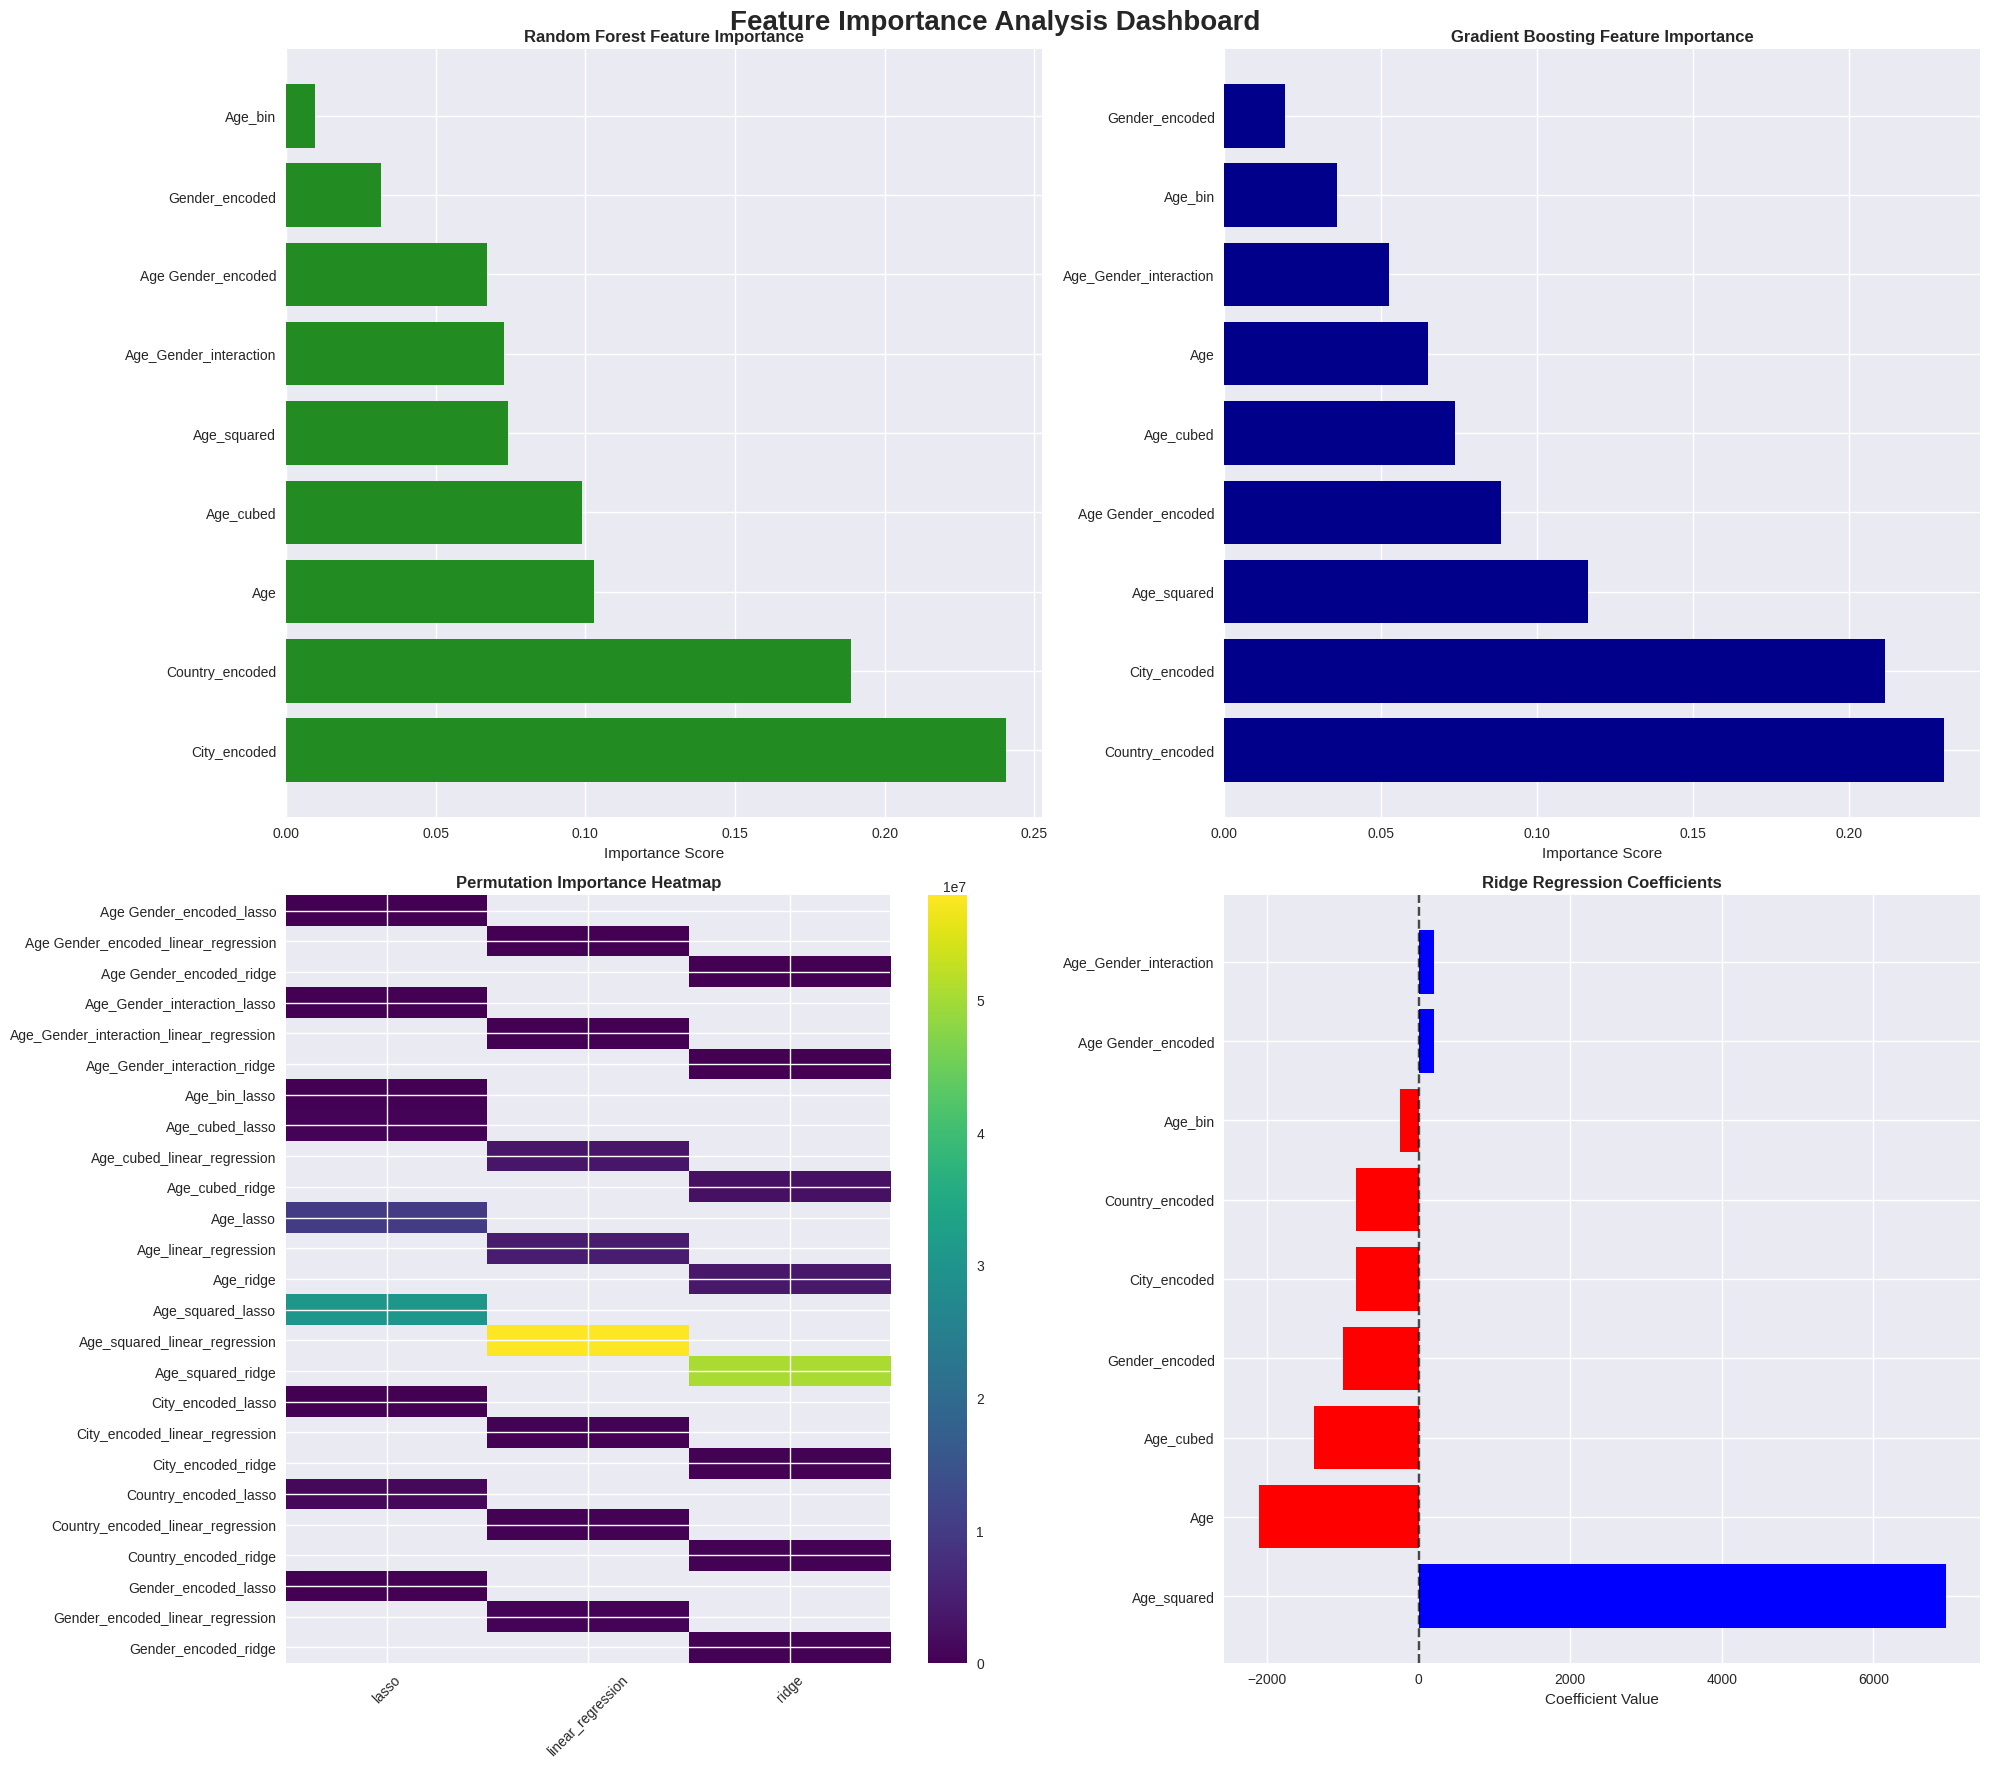

In [ ]:
print("Performing feature importance and interpretability analysis...")

feature_importance_results = {}
tree_based_models = ['decision_tree', 'random_forest', 'gradient_boosting']
for model_name in tree_based_models:
    if model_name in best_models:
        model = best_models[model_name]
        if hasattr(model, 'feature_importances_'):
            importance_scores = model.feature_importances_
            feature_importance_results[model_name] = dict(zip(all_feature_names, importance_scores)) # Use all_feature_names

permutation_importance_results = {}
top_5_models = list(model_results.keys())[:5]

for model_name in top_5_models:
    if model_name in best_models:
        print(f"Computing permutation importance for {model_name}...")
        model = best_models[model_name]

        try:
            perm_importance = permutation_importance(
                model, X_test_best, y_test,
                n_repeats=10, random_state=42,
                scoring='neg_mean_squared_error'
            )

            importance_mean = perm_importance.importances_mean
            importance_std = perm_importance.importances_std

            permutation_importance_results[model_name] = {
                'importance_mean': importance_mean,
                'importance_std': importance_std,
                'feature_names': all_feature_names
            }

        except Exception as e:
            print(f"Error computing permutation importance for {model_name}: {e}")

linear_models = ['linear_regression', 'ridge', 'lasso', 'elastic_net']
coefficient_results = {}

for model_name in linear_models:
    if model_name in best_models:
        model = best_models[model_name]
        if hasattr(model, 'coef_'):
            coefficients = model.coef_
            coefficient_results[model_name] = dict(zip(all_feature_names, coefficients)) # Use all_feature_names

fig, axes = plt.subplots(2, 2, figsize=(20, 18))
fig.suptitle('Feature Importance Analysis Dashboard', fontsize=20, fontweight='bold')

if 'random_forest' in feature_importance_results:
    rf_importance = feature_importance_results['random_forest']
    sorted_features = sorted(rf_importance.items(), key=lambda x: x[1], reverse=True)[:15]
    features, importances = zip(*sorted_features)

    axes[0,0].barh(range(len(features)), importances, color='forestgreen')
    axes[0,0].set_yticks(range(len(features)))
    axes[0,0].set_yticklabels(features)
    axes[0,0].set_title('Random Forest Feature Importance', fontweight='bold')
    axes[0,0].set_xlabel('Importance Score')

if 'gradient_boosting' in feature_importance_results:
    gb_importance = feature_importance_results['gradient_boosting']
    sorted_features = sorted(gb_importance.items(), key=lambda x: x[1], reverse=True)[:15]
    features, importances = zip(*sorted_features)

    axes[0,1].barh(range(len(features)), importances, color='darkblue')
    axes[0,1].set_yticks(range(len(features)))
    axes[0,1].set_yticklabels(features)
    axes[0,1].set_title('Gradient Boosting Feature Importance', fontweight='bold')
    axes[0,1].set_xlabel('Importance Score')

if permutation_importance_results:
    model_names = list(permutation_importance_results.keys())[:3]
    importance_data = []

    for model_name in model_names:
        importance_mean = permutation_importance_results[model_name]['importance_mean']
        feature_names_perm = permutation_importance_results[model_name]['feature_names'] # Use correct variable name
        top_indices = np.argsort(importance_mean)[-10:]

        for idx in top_indices:
            importance_data.append({
                'model': model_name,
                'feature': feature_names_perm[idx],
                'importance': importance_mean[idx]
            })

    if importance_data:
        perm_df = pd.DataFrame(importance_data)
        perm_df['feature_model'] = perm_df['feature'] + '_' + perm_df['model']
        perm_df = perm_df.drop_duplicates(subset=['feature', 'model'])
        pivot_df = perm_df.pivot(index='feature_model', columns='model', values='importance')

        im = axes[1,0].imshow(pivot_df.values, cmap='viridis', aspect='auto')
        axes[1,0].set_xticks(range(len(pivot_df.columns)))
        axes[1,0].set_yticks(range(len(pivot_df.index)))
        axes[1,0].set_xticklabels(pivot_df.columns, rotation=45)
        axes[1,0].set_yticklabels(pivot_df.index)
        axes[1,0].set_title('Permutation Importance Heatmap', fontweight='bold')
        plt.colorbar(im, ax=axes[1,0])

if 'ridge' in coefficient_results:
    ridge_coef = coefficient_results['ridge']
    sorted_coef = sorted(ridge_coef.items(), key=lambda x: abs(x[1]), reverse=True)[:15]
    features, coefficients = zip(*sorted_coef)

    colors = ['red' if c < 0 else 'blue' for c in coefficients]
    axes[1,1].barh(range(len(features)), coefficients, color=colors)
    axes[1,1].set_yticks(range(len(features)))
    axes[1,1].set_yticklabels(features)
    axes[1,1].set_title('Ridge Regression Coefficients', fontweight='bold')
    axes[1,1].set_xlabel('Coefficient Value')
    axes[1,1].axvline(x=0, color='black', linestyle='--', alpha=0.7)

if len(permutation_importance_results) >= 2:
    model1, model2 = list(permutation_importance_results.keys())[:2]
    imp1 = permutation_importance_results[model1]['importance_mean']
    imp2 = permutation_importance_results[model2]['importance_mean']
top_features_summary = {}
for model_name, importance_dict in feature_importance_results.items():
    sorted_features = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
    top_features_summary[model_name] = [f[0] for f in sorted_features[:5]]

plt.tight_layout()
plt.show()

# Print feature importance summary

In [ ]:
print("\nFeature Importance Summary:")
print("=" * 50)
for model_name, importance_dict in feature_importance_results.items():
    print(f"\n{model_name.upper()} - Top 5 Features:")
    sorted_features = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)[:5]
    for i, (feature, importance) in enumerate(sorted_features, 1):
        print(f"  {i}. {feature}: {importance:.4f}")

print("\nFeature interpretability analysis completed!")


Feature Importance Summary:

DECISION_TREE - Top 5 Features:
  1. Country_encoded: 0.3677
  2. Age_squared: 0.0786
  3. Age_Gender_interaction: 0.0609
  4. Gender_encoded: 0.0399
  5. City_encoded: 0.0274

RANDOM_FOREST - Top 5 Features:
  1. City_encoded: 0.2404
  2. Country_encoded: 0.1889
  3. Age: 0.1030
  4. Age_cubed: 0.0989
  5. Age_squared: 0.0742

GRADIENT_BOOSTING - Top 5 Features:
  1. Country_encoded: 0.2303
  2. City_encoded: 0.2115
  3. Age_squared: 0.1162
  4. Age Gender_encoded: 0.0886
  5. Age_cubed: 0.0739

Feature interpretability analysis completed!


# Model Diagnostics and Residual Analysis


Performing comprehensive model diagnostics...
Residual Analysis for gradient_boosting:
Jarque-Bera test p-value: 0.000000
Shapiro-Wilk test p-value: 0.000000
Breusch-Pagan test p-value (homoscedasticity): 0.000000
Durbin-Watson statistic: 1.9613


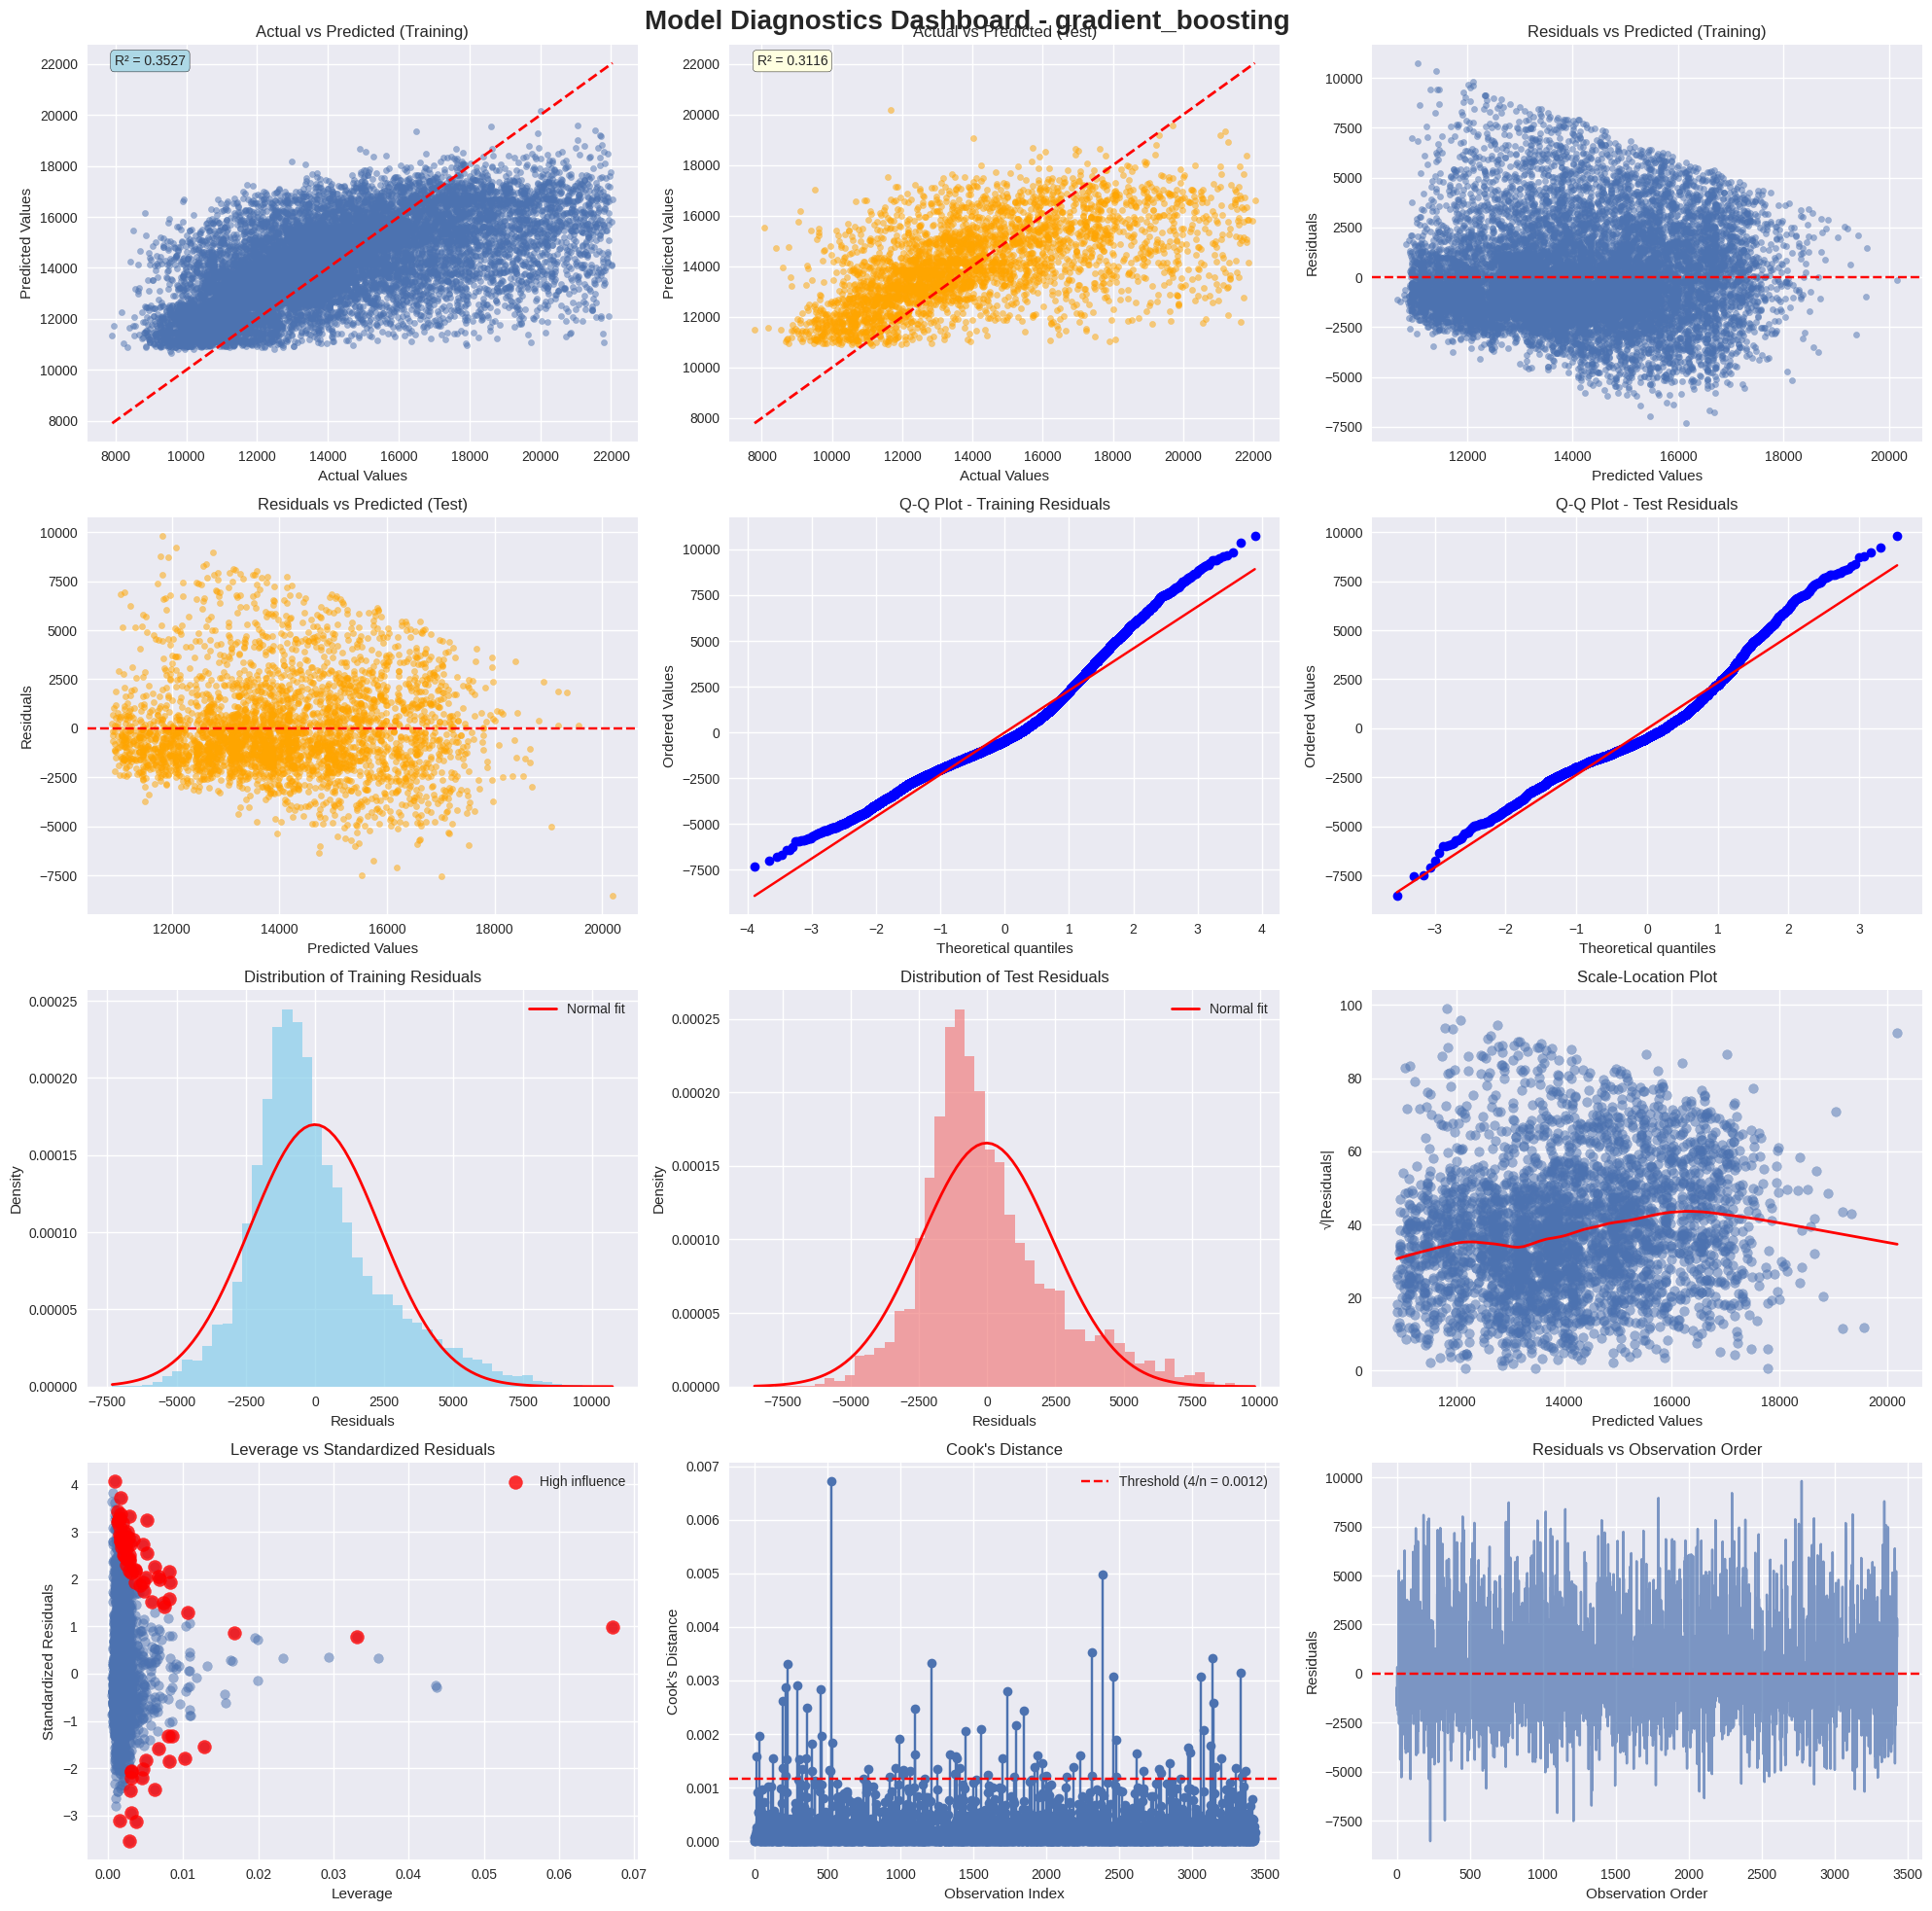


Diagnostic Metrics:
Mean Absolute Error (Test): 1828.47
Root Mean Squared Error (Test): 2409.74
Mean Absolute Percentage Error (Test): 12.93%
Max Residual: 9813.16
Residual Standard Deviation: 2409.66
Number of outliers (>3σ): 35
Percentage of outliers: 1.02%

Potential Issues Detected:
  - Residuals are not normally distributed
  - Residuals fail normality test (Shapiro-Wilk)

Model diagnostics completed!


In [ ]:
print("Performing comprehensive model diagnostics...")

best_model_name = results_df.index[0]
best_model = best_models[best_model_name] if best_model_name in best_models else None

if best_model is not None:
    y_pred_train_best = model_results[best_model_name]['y_pred_train']
    y_pred_test_best = model_results[best_model_name]['y_pred_test']

    train_residuals = y_train - y_pred_train_best
    test_residuals = y_test - y_pred_test_best

    print(f"Residual Analysis for {best_model_name}:")
    print("=" * 40)

    jb_stat, jb_pvalue = jarque_bera(test_residuals)
    sw_stat, sw_pvalue = shapiro(test_residuals[:5000] if len(test_residuals) > 5000 else test_residuals)

    print(f"Jarque-Bera test p-value: {jb_pvalue:.6f}")
    print(f"Shapiro-Wilk test p-value: {sw_pvalue:.6f}")

    try:
        from statsmodels.stats.diagnostic import het_breuschpagan
        from statsmodels.regression.linear_model import OLS
        import statsmodels.api as sm

        X_with_const = sm.add_constant(X_test_best)
        ols_model = OLS(y_test, X_with_const).fit()
        bp_stat, bp_pvalue, _, _ = het_breuschpagan(ols_model.resid, X_with_const)
        print(f"Breusch-Pagan test p-value (homoscedasticity): {bp_pvalue:.6f}")
    except:
        print("Could not perform Breusch-Pagan test")

    try:
        dw_stat = durbin_watson(test_residuals)
        print(f"Durbin-Watson statistic: {dw_stat:.4f}")
    except:
        print("Could not compute Durbin-Watson statistic")

    fig, axes = plt.subplots(4, 3, figsize=(20, 20))
    fig.suptitle(f'Model Diagnostics Dashboard - {best_model_name}', fontsize=20, fontweight='bold')

    axes[0,0].scatter(y_train, y_pred_train_best, alpha=0.5, s=20)
    axes[0,0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
    axes[0,0].set_xlabel('Actual Values')
    axes[0,0].set_ylabel('Predicted Values')
    axes[0,0].set_title('Actual vs Predicted (Training)')
    train_r2 = r2_score(y_train, y_pred_train_best)
    axes[0,0].text(0.05, 0.95, f'R² = {train_r2:.4f}', transform=axes[0,0].transAxes,
                   bbox=dict(boxstyle="round", facecolor='lightblue'))

    axes[0,1].scatter(y_test, y_pred_test_best, alpha=0.5, s=20, color='orange')
    axes[0,1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[0,1].set_xlabel('Actual Values')
    axes[0,1].set_ylabel('Predicted Values')
    axes[0,1].set_title('Actual vs Predicted (Test)')
    test_r2 = r2_score(y_test, y_pred_test_best)
    axes[0,1].text(0.05, 0.95, f'R² = {test_r2:.4f}', transform=axes[0,1].transAxes,
                   bbox=dict(boxstyle="round", facecolor='lightyellow'))

    axes[0,2].scatter(y_pred_train_best, train_residuals, alpha=0.5, s=20)
    axes[0,2].axhline(y=0, color='red', linestyle='--')
    axes[0,2].set_xlabel('Predicted Values')
    axes[0,2].set_ylabel('Residuals')
    axes[0,2].set_title('Residuals vs Predicted (Training)')

    axes[1,0].scatter(y_pred_test_best, test_residuals, alpha=0.5, s=20, color='orange')
    axes[1,0].axhline(y=0, color='red', linestyle='--')
    axes[1,0].set_xlabel('Predicted Values')
    axes[1,0].set_ylabel('Residuals')
    axes[1,0].set_title('Residuals vs Predicted (Test)')

    stats.probplot(train_residuals, dist="norm", plot=axes[1,1])
    axes[1,1].set_title('Q-Q Plot - Training Residuals')

    stats.probplot(test_residuals, dist="norm", plot=axes[1,2])
    axes[1,2].set_title('Q-Q Plot - Test Residuals')

    axes[2,0].hist(train_residuals, bins=50, alpha=0.7, color='skyblue', density=True)
    axes[2,0].set_xlabel('Residuals')
    axes[2,0].set_ylabel('Density')
    axes[2,0].set_title('Distribution of Training Residuals')

    mu, sigma = stats.norm.fit(train_residuals)
    x = np.linspace(train_residuals.min(), train_residuals.max(), 100)
    axes[2,0].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal fit')
    axes[2,0].legend()

    axes[2,1].hist(test_residuals, bins=50, alpha=0.7, color='lightcoral', density=True)
    axes[2,1].set_xlabel('Residuals')
    axes[2,1].set_ylabel('Density')
    axes[2,1].set_title('Distribution of Test Residuals')

    mu, sigma = stats.norm.fit(test_residuals)
    x = np.linspace(test_residuals.min(), test_residuals.max(), 100)
    axes[2,1].plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal fit')
    axes[2,1].legend()

    sqrt_abs_residuals = np.sqrt(np.abs(test_residuals))
    axes[2,2].scatter(y_pred_test_best, sqrt_abs_residuals, alpha=0.5)
    axes[2,2].set_xlabel('Predicted Values')
    axes[2,2].set_ylabel('√|Residuals|')
    axes[2,2].set_title('Scale-Location Plot')

    try:
        from statsmodels.nonparametric.smoothers_lowess import lowess
        smoothed = lowess(sqrt_abs_residuals, y_pred_test_best, frac=0.3)
        axes[2,2].plot(smoothed[:, 0], smoothed[:, 1], 'r-', linewidth=2)
    except:
        pass

    n = len(y_test)
    p = X_test_best.shape[1]
    leverage = np.diag(X_test_best @ np.linalg.pinv(X_test_best.T @ X_test_best) @ X_test_best.T)
    standardized_residuals = test_residuals / np.std(test_residuals)
    cooks_d = (standardized_residuals**2 / p) * (leverage / (1 - leverage)**2)

    axes[3,0].scatter(leverage, standardized_residuals, alpha=0.5)
    axes[3,0].set_xlabel('Leverage')
    axes[3,0].set_ylabel('Standardized Residuals')
    axes[3,0].set_title('Leverage vs Standardized Residuals')

    high_influence = cooks_d > 4/n
    if np.any(high_influence):
        axes[3,0].scatter(leverage[high_influence], standardized_residuals[high_influence],
                         color='red', s=100, alpha=0.8, label='High influence')
        axes[3,0].legend()

    axes[3,1].stem(range(len(cooks_d)), cooks_d, basefmt=" ")
    axes[3,1].axhline(y=4/n, color='red', linestyle='--', label=f'Threshold (4/n = {4/n:.4f})')
    axes[3,1].set_xlabel('Observation Index')
    axes[3,1].set_ylabel("Cook's Distance")
    axes[3,1].set_title("Cook's Distance")
    axes[3,1].legend()

    axes[3,2].plot(range(len(test_residuals)), test_residuals, alpha=0.7)
    axes[3,2].axhline(y=0, color='red', linestyle='--')
    axes[3,2].set_xlabel('Observation Order')
    axes[3,2].set_ylabel('Residuals')
    axes[3,2].set_title('Residuals vs Observation Order')

    plt.tight_layout()
    plt.show()

    print("\nDiagnostic Metrics:")
    print("=" * 30)
    print(f"Mean Absolute Error (Test): {mean_absolute_error(y_test, y_pred_test_best):.2f}")
    print(f"Root Mean Squared Error (Test): {np.sqrt(mean_squared_error(y_test, y_pred_test_best)):.2f}")
    print(f"Mean Absolute Percentage Error (Test): {np.mean(np.abs((y_test - y_pred_test_best) / y_test)) * 100:.2f}%")
    print(f"Max Residual: {np.max(np.abs(test_residuals)):.2f}")
    print(f"Residual Standard Deviation: {np.std(test_residuals):.2f}")
    print(f"Number of outliers (>3σ): {np.sum(np.abs(test_residuals) > 3 * np.std(test_residuals))}")
    print(f"Percentage of outliers: {np.sum(np.abs(test_residuals) > 3 * np.std(test_residuals)) / len(test_residuals) * 100:.2f}%")

    issues = []
    if jb_pvalue < 0.05:
        issues.append("Residuals are not normally distributed")
    if sw_pvalue < 0.05:
        issues.append("Residuals fail normality test (Shapiro-Wilk)")
    if np.sum(np.abs(test_residuals) > 3 * np.std(test_residuals)) / len(test_residuals) > 0.05:
        issues.append("High percentage of outliers detected")

    if issues:
        print("\nPotential Issues Detected:")
        for issue in issues:
            print(f"  - {issue}")
    else:
        print("\nNo major diagnostic issues detected")

print("\nModel diagnostics completed!")

# Cross-Validation Strategy Comparison and Learning Curves

In [ ]:
print("Performing cross-validation strategy comparison...")

from sklearn.model_selection import KFold, StratifiedKFold, TimeSeriesSplit, ShuffleSplit, LeaveOneOut
from sklearn.model_selection import learning_curve, validation_curve

cv_strategies = {
    'KFold_5': KFold(n_splits=5, shuffle=True, random_state=42),
    'KFold_10': KFold(n_splits=10, shuffle=True, random_state=42),
    'ShuffleSplit': ShuffleSplit(n_splits=10, test_size=0.2, random_state=42),
    'TimeSeriesSplit': TimeSeriesSplit(n_splits=5)
}

y_binned = pd.cut(y_train, bins=5, labels=False)

top_3_models = list(model_results.keys())[:3]
cv_results = {}

for model_name in top_3_models:
    if model_name in best_models:
        model = best_models[model_name]
        cv_results[model_name] = {}

        print(f"\nTesting CV strategies for {model_name}...")

        for cv_name, cv_strategy in cv_strategies.items():
            try:
                scores = cross_val_score(model, X_train_best, y_train,
                                       cv=cv_strategy, scoring='neg_mean_squared_error')
                rmse_scores = np.sqrt(-scores)

                cv_results[model_name][cv_name] = {
                    'mean_rmse': rmse_scores.mean(),
                    'std_rmse': rmse_scores.std(),
                    'scores': rmse_scores
                }
                print(f"  {cv_name}: RMSE = {rmse_scores.mean():.3f} ± {rmse_scores.std():.3f}")
            except Exception as e:
                print(f"  {cv_name}: Error - {str(e)}")
print("\nGenerating learning curves...")
learning_curve_results = {}

for model_name in top_3_models[:2]:
    if model_name in best_models:
        model = best_models[model_name]

        print(f"Computing learning curve for {model_name}...")

        train_sizes = np.linspace(0.1, 1.0, 10)
        train_sizes_abs, train_scores, val_scores = learning_curve(
            model, X_train_best, y_train, cv=5,
            train_sizes=train_sizes, scoring='neg_mean_squared_error',
            random_state=42, n_jobs=-1
        )

        train_rmse = np.sqrt(-train_scores)
        val_rmse = np.sqrt(-val_scores)

        learning_curve_results[model_name] = {
            'train_sizes': train_sizes_abs,
            'train_rmse_mean': train_rmse.mean(axis=1),
            'train_rmse_std': train_rmse.std(axis=1),
            'val_rmse_mean': val_rmse.mean(axis=1),
            'val_rmse_std': val_rmse.std(axis=1)
        }

print("\nGenerating validation curves...")
validation_curve_results = {}

if 'random_forest' in best_models:
    param_range = [10, 25, 50, 100, 200, 300, 500]
    train_scores, val_scores = validation_curve(
        RandomForestRegressor(random_state=42), X_train_best, y_train,
        param_name='n_estimators', param_range=param_range,
        cv=5, scoring='neg_mean_squared_error', n_jobs=-1
    )

    validation_curve_results['random_forest_n_estimators'] = {
        'param_range': param_range,
        'train_rmse_mean': np.sqrt(-train_scores).mean(axis=1),
        'train_rmse_std': np.sqrt(-train_scores).std(axis=1),
        'val_rmse_mean': np.sqrt(-val_scores).mean(axis=1),
        'val_rmse_std': np.sqrt(-val_scores).std(axis=1)
    }

if 'ridge' in best_models:
    param_range = [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
    train_scores, val_scores = validation_curve(
        Ridge(), X_train_best, y_train,
        param_name='alpha', param_range=param_range,
        cv=5, scoring='neg_mean_squared_error'
    )

    validation_curve_results['ridge_alpha'] = {
        'param_range': param_range,
        'train_rmse_mean': np.sqrt(-train_scores).mean(axis=1),
        'train_rmse_std': np.sqrt(-train_scores).std(axis=1),
        'val_rmse_mean': np.sqrt(-val_scores).mean(axis=1),
        'val_rmse_std': np.sqrt(-val_scores).std(axis=1)
    }

Performing cross-validation strategy comparison...

Testing CV strategies for linear_regression...
  KFold_5: RMSE = 2554.811 ± 38.506
  KFold_10: RMSE = 2554.397 ± 46.970
  ShuffleSplit: RMSE = 2552.049 ± 27.515
  TimeSeriesSplit: RMSE = 2557.502 ± 26.568

Testing CV strategies for ridge...
  KFold_5: RMSE = 2554.806 ± 38.416
  KFold_10: RMSE = 2554.396 ± 46.865
  ShuffleSplit: RMSE = 2552.034 ± 27.552
  TimeSeriesSplit: RMSE = 2557.258 ± 26.432

Testing CV strategies for lasso...
  KFold_5: RMSE = 2554.886 ± 38.189
  KFold_10: RMSE = 2554.483 ± 46.570
  ShuffleSplit: RMSE = 2552.085 ± 27.619
  TimeSeriesSplit: RMSE = 2557.357 ± 26.525

Generating learning curves...
Computing learning curve for linear_regression...
Computing learning curve for ridge...

Generating validation curves...


# Comprehensive Visualization

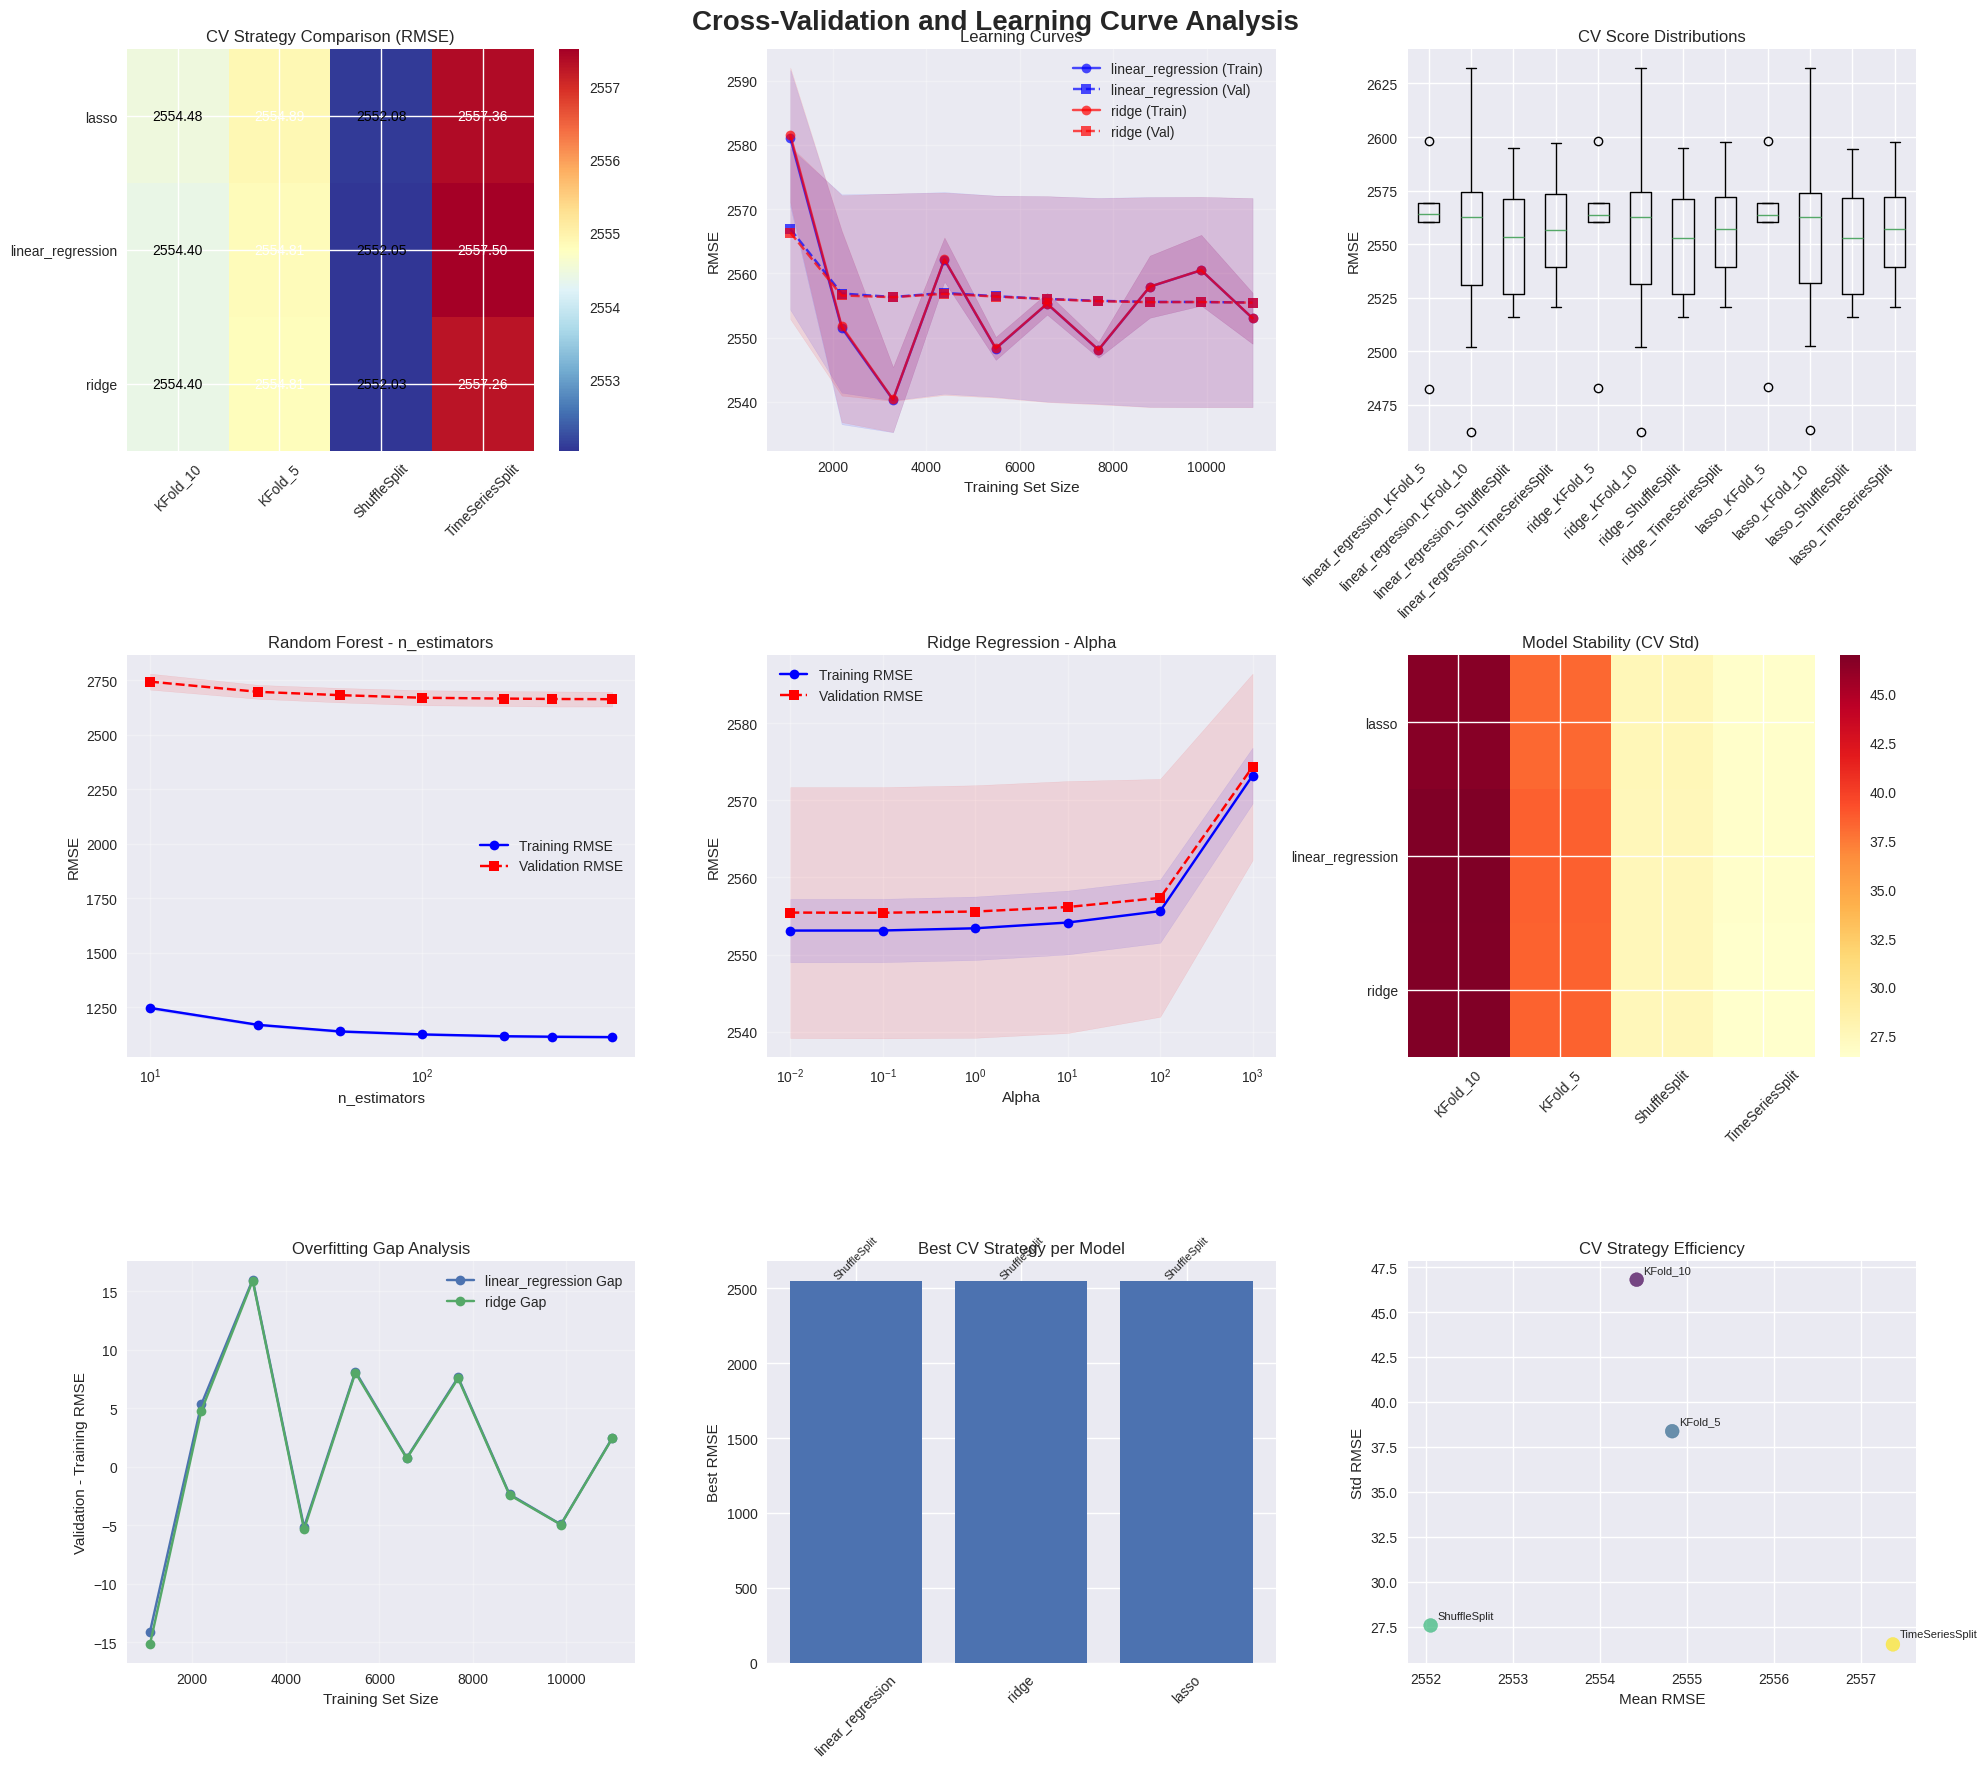


Cross-validation analysis completed!


In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(20, 18))
fig.suptitle('Cross-Validation and Learning Curve Analysis', fontsize=20, fontweight='bold')

if cv_results:
    cv_comparison_data = []
    for model in cv_results:
        for cv_strategy in cv_results[model]:
            cv_comparison_data.append({
                'Model': model,
                'CV_Strategy': cv_strategy,
                'RMSE': cv_results[model][cv_strategy]['mean_rmse']
            })

    if cv_comparison_data:
        cv_df = pd.DataFrame(cv_comparison_data)
        pivot_df = cv_df.pivot(index='Model', columns='CV_Strategy', values='RMSE')

        im = axes[0,0].imshow(pivot_df.values, cmap='RdYlBu_r', aspect='auto')
        axes[0,0].set_xticks(range(len(pivot_df.columns)))
        axes[0,0].set_yticks(range(len(pivot_df.index)))
        axes[0,0].set_xticklabels(pivot_df.columns, rotation=45)
        axes[0,0].set_yticklabels(pivot_df.index)
        axes[0,0].set_title('CV Strategy Comparison (RMSE)')

        for i in range(len(pivot_df.index)):
            for j in range(len(pivot_df.columns)):
                if not pd.isna(pivot_df.iloc[i, j]):
                    axes[0,0].text(j, i, f'{pivot_df.iloc[i, j]:.2f}',
                                 ha="center", va="center", color="white" if pivot_df.iloc[i, j] > pivot_df.values.mean() else "black")

        plt.colorbar(im, ax=axes[0,0])

if learning_curve_results:
    colors = ['blue', 'red', 'green']
    for i, (model_name, results) in enumerate(learning_curve_results.items()):
        color = colors[i % len(colors)]

        axes[0,1].plot(results['train_sizes'], results['train_rmse_mean'],
                      'o-', color=color, label=f'{model_name} (Train)', alpha=0.7)
        axes[0,1].fill_between(results['train_sizes'],
                              results['train_rmse_mean'] - results['train_rmse_std'],
                              results['train_rmse_mean'] + results['train_rmse_std'],
                              alpha=0.1, color=color)

        axes[0,1].plot(results['train_sizes'], results['val_rmse_mean'],
                      's--', color=color, label=f'{model_name} (Val)', alpha=0.7)
        axes[0,1].fill_between(results['train_sizes'],
                              results['val_rmse_mean'] - results['val_rmse_std'],
                              results['val_rmse_mean'] + results['val_rmse_std'],
                              alpha=0.1, color=color)

    axes[0,1].set_xlabel('Training Set Size')
    axes[0,1].set_ylabel('RMSE')
    axes[0,1].set_title('Learning Curves')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

if cv_results:
    model_names = list(cv_results.keys())
    if model_names:
        model_scores = []
        labels = []

        for model in model_names:
            for cv_strategy in cv_results[model]:
                scores = cv_results[model][cv_strategy]['scores']
                model_scores.append(scores)
                labels.append(f"{model}_{cv_strategy}")

        if model_scores:
            axes[0,2].boxplot(model_scores, labels=range(len(labels)))
            axes[0,2].set_xticklabels(labels, rotation=45, ha='right')
            axes[0,2].set_ylabel('RMSE')
            axes[0,2].set_title('CV Score Distributions')

if 'random_forest_n_estimators' in validation_curve_results:
    results = validation_curve_results['random_forest_n_estimators']
    axes[1,0].semilogx(results['param_range'], results['train_rmse_mean'],
                      'o-', label='Training RMSE', color='blue')
    axes[1,0].fill_between(results['param_range'],
                          results['train_rmse_mean'] - results['train_rmse_std'],
                          results['train_rmse_mean'] + results['train_rmse_std'],
                          alpha=0.1, color='blue')

    axes[1,0].semilogx(results['param_range'], results['val_rmse_mean'],
                      's--', label='Validation RMSE', color='red')
    axes[1,0].fill_between(results['param_range'],
                          results['val_rmse_mean'] - results['val_rmse_std'],
                          results['val_rmse_mean'] + results['val_rmse_std'],
                          alpha=0.1, color='red')

    axes[1,0].set_xlabel('n_estimators')
    axes[1,0].set_ylabel('RMSE')
    axes[1,0].set_title('Random Forest - n_estimators')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

if 'ridge_alpha' in validation_curve_results:
    results = validation_curve_results['ridge_alpha']
    axes[1,1].semilogx(results['param_range'], results['train_rmse_mean'],
                      'o-', label='Training RMSE', color='blue')
    axes[1,1].fill_between(results['param_range'],
                          results['train_rmse_mean'] - results['train_rmse_std'],
                          results['train_rmse_mean'] + results['train_rmse_std'],
                          alpha=0.1, color='blue')

    axes[1,1].semilogx(results['param_range'], results['val_rmse_mean'],
                      's--', label='Validation RMSE', color='red')
    axes[1,1].fill_between(results['param_range'],
                          results['val_rmse_mean'] - results['val_rmse_std'],
                          results['val_rmse_mean'] + results['val_rmse_std'],
                          alpha=0.1, color='red')

    axes[1,1].set_xlabel('Alpha')
    axes[1,1].set_ylabel('RMSE')
    axes[1,1].set_title('Ridge Regression - Alpha')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)

if cv_results:
    stability_data = []
    for model in cv_results:
        for cv_strategy in cv_results[model]:
            stability_data.append({
                'Model': model,
                'CV_Strategy': cv_strategy,
                'CV_Std': cv_results[model][cv_strategy]['std_rmse']
            })

    if stability_data:
        stability_df = pd.DataFrame(stability_data)
        pivot_stability = stability_df.pivot(index='Model', columns='CV_Strategy', values='CV_Std')

        im = axes[1,2].imshow(pivot_stability.values, cmap='YlOrRd', aspect='auto')
        axes[1,2].set_xticks(range(len(pivot_stability.columns)))
        axes[1,2].set_yticks(range(len(pivot_stability.index)))
        axes[1,2].set_xticklabels(pivot_stability.columns, rotation=45)
        axes[1,2].set_yticklabels(pivot_stability.index)
        axes[1,2].set_title('Model Stability (CV Std)')
        plt.colorbar(im, ax=axes[1,2])

if learning_curve_results:
    for model_name, results in learning_curve_results.items():
        gap = results['val_rmse_mean'] - results['train_rmse_mean']
        axes[2,0].plot(results['train_sizes'], gap, 'o-', label=f'{model_name} Gap')

    axes[2,0].set_xlabel('Training Set Size')
    axes[2,0].set_ylabel('Validation - Training RMSE')
    axes[2,0].set_title('Overfitting Gap Analysis')
    axes[2,0].legend()
    axes[2,0].grid(True, alpha=0.3)

if cv_results:
    best_cv_data = []
    for model in cv_results:
        best_cv = min(cv_results[model].items(), key=lambda x: x[1]['mean_rmse'])
        best_cv_data.append({
            'Model': model,
            'Best_CV': best_cv[0],
            'Best_RMSE': best_cv[1]['mean_rmse']
        })

    if best_cv_data:
        best_cv_df = pd.DataFrame(best_cv_data)
        bars = axes[2,1].bar(best_cv_df['Model'], best_cv_df['Best_RMSE'])
        axes[2,1].set_ylabel('Best RMSE')
        axes[2,1].set_title('Best CV Strategy per Model')
        axes[2,1].tick_params(axis='x', rotation=45)

        for i, (bar, cv_strategy) in enumerate(zip(bars, best_cv_df['Best_CV'])):
            height = bar.get_height()
            axes[2,1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                          cv_strategy, ha='center', va='bottom', rotation=45, fontsize=8)

cv_efficiency = []
for model in cv_results:
    for cv_strategy in cv_results[model]:
        cv_efficiency.append({
            'Strategy': cv_strategy,
            'Mean_RMSE': cv_results[model][cv_strategy]['mean_rmse'],
            'Std_RMSE': cv_results[model][cv_strategy]['std_rmse']
        })

if cv_efficiency:
    eff_df = pd.DataFrame(cv_efficiency)
    strategy_summary = eff_df.groupby('Strategy').agg({
        'Mean_RMSE': 'mean',
        'Std_RMSE': 'mean'
    }).reset_index()

    scatter = axes[2,2].scatter(strategy_summary['Mean_RMSE'], strategy_summary['Std_RMSE'],
                               s=100, alpha=0.7, c=range(len(strategy_summary)), cmap='viridis')

    for i, row in strategy_summary.iterrows():
        axes[2,2].annotate(row['Strategy'],
                          (row['Mean_RMSE'], row['Std_RMSE']),
                          xytext=(5, 5), textcoords='offset points', fontsize=8)

    axes[2,2].set_xlabel('Mean RMSE')
    axes[2,2].set_ylabel('Std RMSE')
    axes[2,2].set_title('CV Strategy Efficiency')

plt.tight_layout()
plt.show()

print("\nCross-validation analysis completed!")

# Advanced Feature Engineering and Polynomial Features

In [ ]:

print("Performing advanced feature engineering...")

from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression

print("Creating polynomial features...")
poly_features = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train_best)
X_test_poly = poly_features.transform(X_test_best)

print(f"Original features: {X_train_best.shape[1]}")
print(f"Polynomial features: {X_train_poly.shape[1]}")

print("Performing feature selection on polynomial features...")
selector_poly = SelectKBest(score_func=f_regression, k=min(50, X_train_poly.shape[1]))
X_train_poly_selected = selector_poly.fit_transform(X_train_poly, y_train)
X_test_poly_selected = selector_poly.transform(X_test_poly)

print(f"Selected polynomial features: {X_train_poly_selected.shape[1]}")

print("Creating advanced engineered features...")

ratio_features_train = []
ratio_features_test = []
ratio_names = []

important_features = ['Age', 'M40-44', 'Overall', 'Gender', 'Country']
available_features = [f for f in important_features if f in all_feature_names]

for i, feat1 in enumerate(available_features):
    for feat2 in available_features[i+1:]:
        idx1 = all_feature_names.index(feat1)
        idx2 = all_feature_names.index(feat2)

        train_ratio = np.where(X_train_best[:, idx2] != 0,
                              X_train_best[:, idx1] / (X_train_best[:, idx2] + 1e-8), 0)
        test_ratio = np.where(X_test_best[:, idx2] != 0,
                             X_test_best[:, idx1] / (X_test_best[:, idx2] + 1e-8), 0)

        ratio_features_train.append(train_ratio)
        ratio_features_test.append(test_ratio)
        ratio_names.append(f'{feat1}_to_{feat2}_ratio')

log_features_train = []
log_features_test = []
log_names = []

for i, feat_name in enumerate(all_feature_names):
    if np.all(X_train_best[:, i] >= 0):
        log_feat_train = np.log1p(X_train_best[:, i])
        log_feat_test = np.log1p(X_test_best[:, i])

        log_features_train.append(log_feat_train)
        log_features_test.append(log_feat_test)
        log_names.append(f'{feat_name}_log')
        sqrt_feat_train = np.sqrt(X_train_best[:, i])
        sqrt_feat_test = np.sqrt(X_test_best[:, i])

        log_features_train.append(sqrt_feat_train)
        log_features_test.append(sqrt_feat_test)
        log_names.append(f'{feat_name}_sqrt')

binned_features_train = []
binned_features_test = []
binned_names = []

for i, feat_name in enumerate(all_feature_names):
    if len(np.unique(X_train_best[:, i])) > 10:
        bins = np.percentile(X_train_best[:, i], [0, 20, 40, 60, 80, 100])
        bins = np.unique(bins)
        if len(bins) > 2:
            train_binned = np.digitize(X_train_best[:, i], bins) - 1
            test_binned = np.digitize(X_test_best[:, i], bins) - 1

            from sklearn.preprocessing import OneHotEncoder
            encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
            train_binned_oh = encoder.fit_transform(train_binned.reshape(-1, 1))
            test_binned_oh = encoder.transform(test_binned.reshape(-1, 1))

            for j in range(train_binned_oh.shape[1]):
                binned_features_train.append(train_binned_oh[:, j])
                binned_features_test.append(test_binned_oh[:, j])
                binned_names.append(f'{feat_name}_bin_{j}')

Performing advanced feature engineering...
Creating polynomial features...
Original features: 11
Polynomial features: 66
Performing feature selection on polynomial features...
Selected polynomial features: 50
Creating advanced engineered features...


# Combine all engineered features

In [ ]:
print("Combining engineered features...")
all_engineered_train = np.column_stack([
    X_train_best,
    np.column_stack(ratio_features_train) if ratio_features_train else np.empty((X_train_best.shape[0], 0)),
    np.column_stack(log_features_train) if log_features_train else np.empty((X_train_best.shape[0], 0)),
    np.column_stack(binned_features_train) if binned_features_train else np.empty((X_train_best.shape[0], 0))
])

all_engineered_test = np.column_stack([
    X_test_best,
    np.column_stack(ratio_features_test) if ratio_features_test else np.empty((X_test_best.shape[0], 0)),
    np.column_stack(log_features_test) if log_features_test else np.empty((X_test_best.shape[0], 0)),
    np.column_stack(binned_features_test) if binned_features_test else np.empty((X_test_best.shape[0], 0))
])

all_engineered_names = all_feature_names + ratio_names + log_names + binned_names

print(f"Total engineered features: {all_engineered_train.shape[1]}")

print("Selecting best engineered features...")
selector_engineered = SelectKBest(score_func=f_regression, k=min(100, all_engineered_train.shape[1]))
X_train_engineered = selector_engineered.fit_transform(all_engineered_train, y_train)
X_test_engineered = selector_engineered.transform(all_engineered_test)

selected_indices = selector_engineered.get_support(indices=True)
selected_engineered_names = [all_engineered_names[i] for i in selected_indices]

print(f"Selected engineered features: {X_train_engineered.shape[1]}")

print("Testing models with engineered features...")
engineered_results = {}

models_to_test = {
    'ridge_engineered': Ridge(alpha=1.0),
    'rf_engineered': RandomForestRegressor(n_estimators=100, random_state=42),
    'gb_engineered': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

for name, model in models_to_test.items():
    print(f"Training {name}...")

    model.fit(X_train_engineered, y_train)

    y_pred_train = model.predict(X_train_engineered)
    y_pred_test = model.predict(X_test_engineered)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)

    engineered_results[name] = {
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'model': model,
        'y_pred_train': y_pred_train,
        'y_pred_test': y_pred_test
    }

    print(f"{name}: Test RMSE = {test_rmse:.3f}, Test R² = {test_r2:.4f}")

print("\nTesting with polynomial features...")
poly_results = {}

models_poly = {
    'ridge_poly': Ridge(alpha=10.0),
    'lasso_poly': Lasso(alpha=1.0),
    'elastic_net_poly': ElasticNet(alpha=1.0, l1_ratio=0.5)
}

for name, model in models_poly.items():
    print(f"Training {name}...")

    model.fit(X_train_poly_selected, y_train)

    y_pred_train = model.predict(X_train_poly_selected)
    y_pred_test = model.predict(X_test_poly_selected)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)

    poly_results[name] = {
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'model': model,
        'y_pred_train': y_pred_train,
        'y_pred_test': y_pred_test
    }

    print(f"{name}: Test RMSE = {test_rmse:.3f}, Test R² = {test_r2:.4f}")

Combining engineered features...
Total engineered features: 55
Selecting best engineered features...
Selected engineered features: 55
Testing models with engineered features...
Training ridge_engineered...
ridge_engineered: Test RMSE = 2458.628, Test R² = 0.2834
Training rf_engineered...
rf_engineered: Test RMSE = 2653.669, Test R² = 0.1652
Training gb_engineered...
gb_engineered: Test RMSE = 2406.460, Test R² = 0.3135

Testing with polynomial features...
Training ridge_poly...
ridge_poly: Test RMSE = 2499.879, Test R² = 0.2592
Training lasso_poly...
lasso_poly: Test RMSE = 2499.743, Test R² = 0.2592
Training elastic_net_poly...
elastic_net_poly: Test RMSE = 2555.905, Test R² = 0.2256


# Visualization of feature engineering results

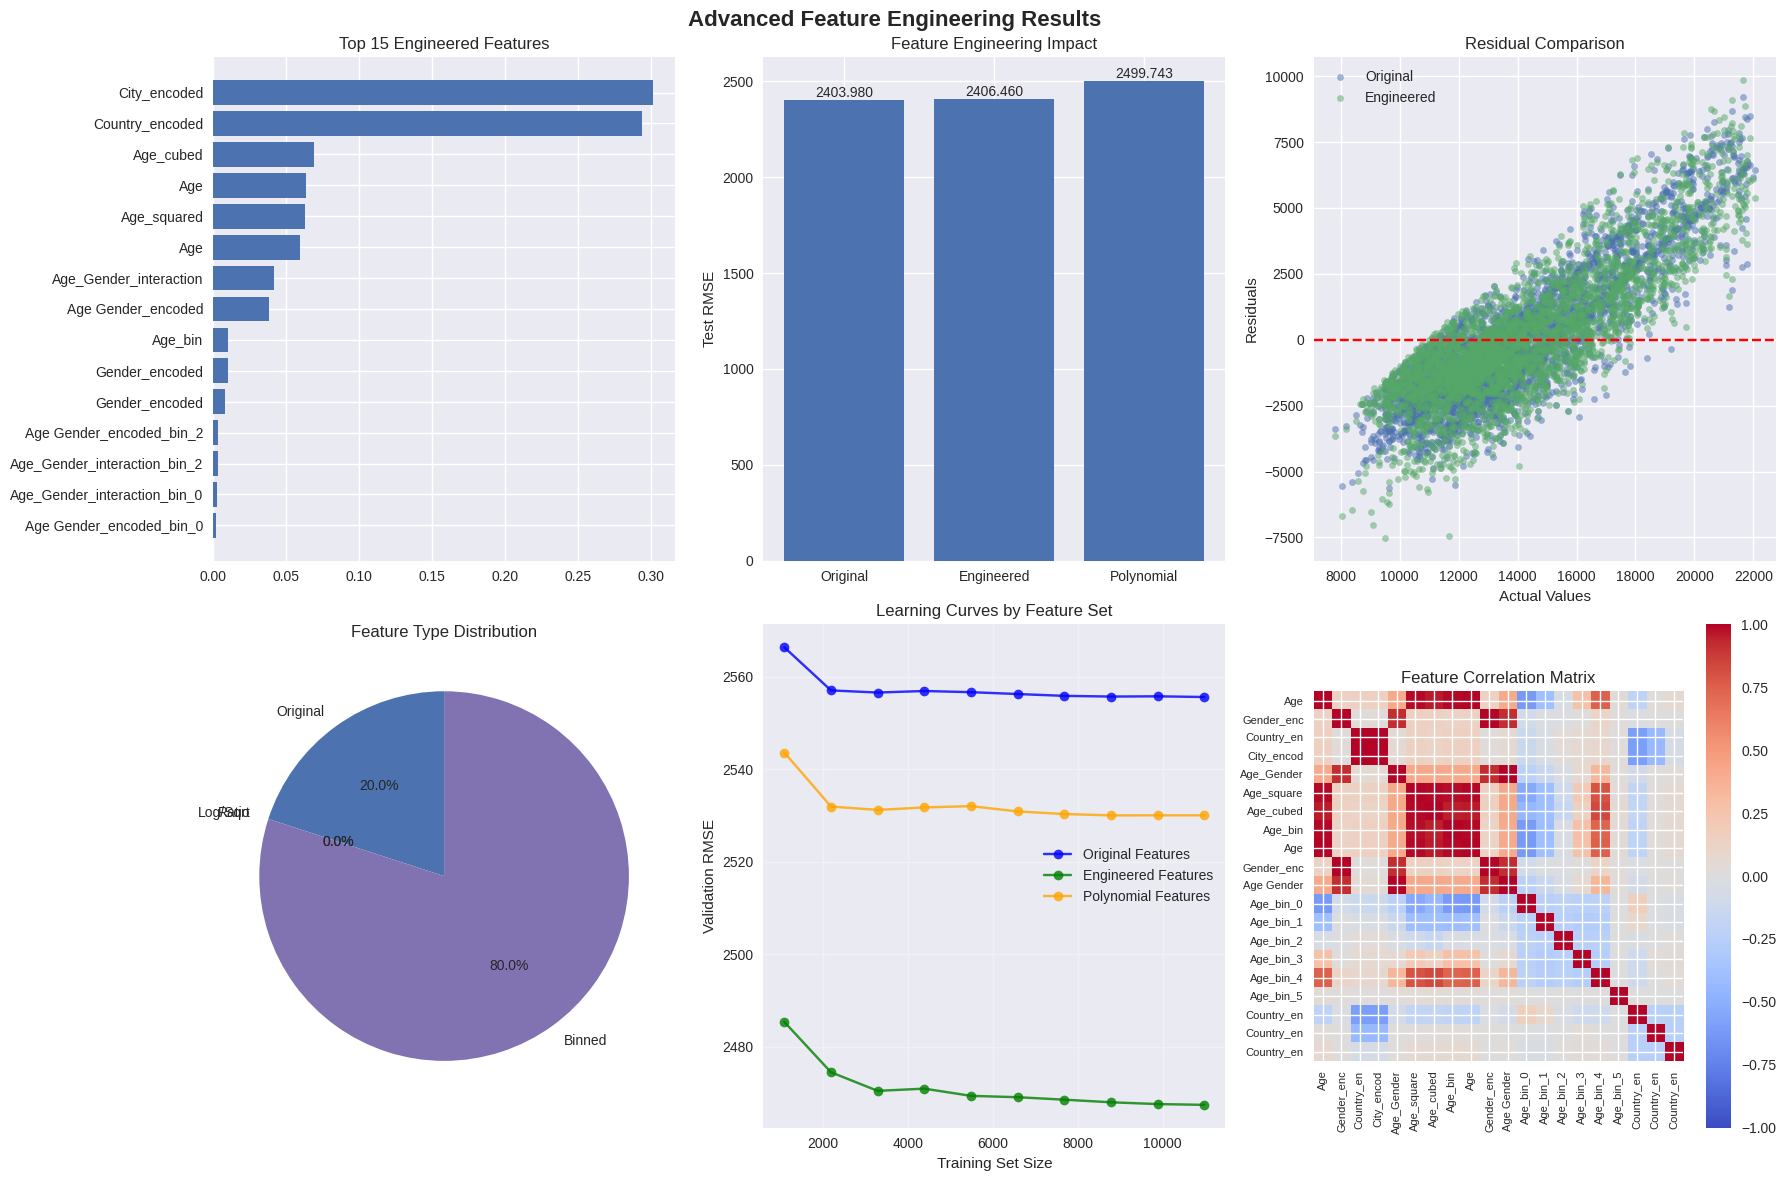


Advanced feature engineering completed!
Best engineered model: gb_engineered with RMSE: 2406.460


In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Advanced Feature Engineering Results', fontsize=16, fontweight='bold')

if 'rf_engineered' in engineered_results:
    model = engineered_results['rf_engineered']['model']
    importances = model.feature_importances_
    indices = np.argsort(importances)[-15:]

    axes[0,0].barh(range(len(indices)), importances[indices])
    axes[0,0].set_yticks(range(len(indices)))
    axes[0,0].set_yticklabels([selected_engineered_names[i] for i in indices])
    axes[0,0].set_title('Top 15 Engineered Features')

original_best = min(model_results.values(), key=lambda x: x['test_rmse'])['test_rmse']
engineered_best = min(engineered_results.values(), key=lambda x: x['test_rmse'])['test_rmse']
poly_best = min(poly_results.values(), key=lambda x: x['test_rmse'])['test_rmse']

performance_data = {
    'Original': original_best,
    'Engineered': engineered_best,
    'Polynomial': poly_best
}

bars = axes[0,1].bar(performance_data.keys(), performance_data.values())
axes[0,1].set_ylabel('Test RMSE')
axes[0,1].set_title('Feature Engineering Impact')
for bar, value in zip(bars, performance_data.values()):
    axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                   f'{value:.3f}', ha='center', va='bottom')

best_engineered = min(engineered_results.items(), key=lambda x: x[1]['test_rmse'])
residuals_engineered = y_test - best_engineered[1]['y_pred_test']
residuals_original = y_test - model_results[list(model_results.keys())[0]]['y_pred_test']

axes[0,2].scatter(y_test, residuals_original, alpha=0.5, label='Original', s=20)
axes[0,2].scatter(y_test, residuals_engineered, alpha=0.5, label='Engineered', s=20)
axes[0,2].axhline(y=0, color='red', linestyle='--')
axes[0,2].set_xlabel('Actual Values')
axes[0,2].set_ylabel('Residuals')
axes[0,2].set_title('Residual Comparison')
axes[0,2].legend()

feature_types = {'Original': len(all_feature_names),
                'Ratio': len(ratio_names),
                'Log/Sqrt': len(log_names),
                'Binned': len(binned_names)}

wedges, texts, autotexts = axes[1,0].pie(feature_types.values(), labels=feature_types.keys(),
                                         autopct='%1.1f%%', startangle=90)
axes[1,0].set_title('Feature Type Distribution')

train_sizes = np.linspace(0.1, 1.0, 10)
feature_sets = {
    'Original': (X_train_best, X_test_best),
    'Engineered': (X_train_engineered, X_test_engineered),
    'Polynomial': (X_train_poly_selected, X_test_poly_selected)
}

colors = ['blue', 'green', 'orange']
for i, (name, (X_tr, X_te)) in enumerate(feature_sets.items()):
    model = Ridge(alpha=1.0)
    train_sizes_abs, train_scores, val_scores = learning_curve(
        model, X_tr, y_train, cv=5, train_sizes=train_sizes,
        scoring='neg_mean_squared_error', random_state=42
    )

    train_rmse = np.sqrt(-train_scores).mean(axis=1)
    val_rmse = np.sqrt(-val_scores).mean(axis=1)

    axes[1,1].plot(train_sizes_abs, val_rmse, 'o-', color=colors[i],
                   label=f'{name} Features', alpha=0.8)

axes[1,1].set_xlabel('Training Set Size')
axes[1,1].set_ylabel('Validation RMSE')
axes[1,1].set_title('Learning Curves by Feature Set')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

if len(selected_engineered_names) > 0:
    n_features = min(20, len(selected_engineered_names))
    top_features = selected_engineered_names[:n_features]
    corr_matrix = np.corrcoef(X_train_engineered[:, :n_features].T)

    im = axes[1,2].imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
    axes[1,2].set_xticks(range(n_features))
    axes[1,2].set_yticks(range(n_features))
    axes[1,2].set_xticklabels([name[:10] for name in top_features], rotation=90, fontsize=8)
    axes[1,2].set_yticklabels([name[:10] for name in top_features], fontsize=8)
    axes[1,2].set_title('Feature Correlation Matrix')
    plt.colorbar(im, ax=axes[1,2])

plt.tight_layout()
plt.show()

print("\nAdvanced feature engineering completed!")
print(f"Best engineered model: {best_engineered[0]} with RMSE: {best_engineered[1]['test_rmse']:.3f}")

# Summary Table

In [ ]:
summary_data = []
for name, results in {**model_results, **engineered_results, **poly_results}.items():
    train_rmse = results.get('train_rmse')
    test_rmse = results.get('test_rmse')
    test_r2 = results.get('test_r2')

    overfitting = None
    if train_rmse is not None and test_rmse is not None:
        overfitting = train_rmse / test_rmse

    summary_data.append({
        'Model': name,
        'Test_RMSE': test_rmse,
        'Test_R2': test_r2,
        'Train_RMSE': train_rmse,
        'Overfitting': overfitting
    })

summary_df = pd.DataFrame(summary_data).sort_values('Test_RMSE')
print("\nModel Performance Summary:")
print(summary_df.to_string(index=False, float_format='%.4f'))


Model Performance Summary:
            Model  Test_RMSE  Test_R2  Train_RMSE  Overfitting
stacking_ensemble  2403.9797   0.3149         NaN          NaN
  voting_ensemble  2406.1881   0.3136         NaN          NaN
    gb_engineered  2406.4597   0.3135   2373.4683       0.9863
weighted_ensemble  2406.5910   0.3134         NaN          NaN
gradient_boosting  2409.7374   0.3116   2349.1438       0.9749
    random_forest  2410.2959   0.3113   2341.7770       0.9716
  custom_ensemble  2413.2040   0.3096         NaN          NaN
              mlp  2433.2018   0.2981   2447.8305       1.0060
    decision_tree  2444.8180   0.2914   2427.8963       0.9931
 ridge_engineered  2458.6285   0.2834   2463.5121       1.0020
              knn  2484.5213   0.2682   2338.7755       0.9413
        ada_boost  2489.0858   0.2655   2499.9803       1.0044
       lasso_poly  2499.7434   0.2592   2526.7811       1.0108
       ridge_poly  2499.8787   0.2592   2526.4660       1.0106
              svr  2507.322

# Ensemble Methods and Stacking

In [ ]:
print("Implementing advanced ensemble methods...")

from sklearn.ensemble import VotingRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

base_models = {
    'ridge': Ridge(alpha=1.0),
    'random_forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'gradient_boost': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'extra_trees': ExtraTreesRegressor(n_estimators=100, random_state=42),
    'ada_boost': AdaBoostRegressor(n_estimators=100, random_state=42),
    'mlp': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42),
    'svr': SVR(kernel='rbf', C=1.0, gamma='scale')
}

print("Training base models...")
base_predictions_train = {}
base_predictions_test = {}
base_models_trained = {}

for name, model in base_models.items():
    print(f"Training {name}...")
    try:
        model.fit(X_train_engineered, y_train)

        pred_train = model.predict(X_train_engineered)
        pred_test = model.predict(X_test_engineered)

        base_predictions_train[name] = pred_train
        base_predictions_test[name] = pred_test
        base_models_trained[name] = model

        rmse = np.sqrt(mean_squared_error(y_test, pred_test))
        print(f"  {name} RMSE: {rmse:.3f}")

    except Exception as e:
        print(f"  {name} failed: {str(e)}")

print("\nCreating voting ensemble...")
voting_models = [(name, model) for name, model in base_models_trained.items()
                if name in ['ridge', 'random_forest', 'gradient_boost']]

voting_regressor = VotingRegressor(estimators=voting_models)
voting_regressor.fit(X_train_engineered, y_train)

voting_pred_train = voting_regressor.predict(X_train_engineered)
voting_pred_test = voting_regressor.predict(X_test_engineered)

voting_rmse = np.sqrt(mean_squared_error(y_test, voting_pred_test))
print(f"Voting Regressor RMSE: {voting_rmse:.3f}")

print("Creating weighted voting ensemble...")
model_weights = []
for name in ['ridge', 'random_forest', 'gradient_boost']:
    if name in base_predictions_test:
        rmse = np.sqrt(mean_squared_error(y_test, base_predictions_test[name]))
        weight = 1.0 / rmse
        model_weights.append(weight)
    else:
        model_weights.append(1.0)

model_weights = np.array(model_weights)
model_weights = model_weights / model_weights.sum()

weighted_pred_train = np.zeros(len(y_train))
weighted_pred_test = np.zeros(len(y_test))

for i, name in enumerate(['ridge', 'random_forest', 'gradient_boost']):
    if name in base_predictions_test:
        weighted_pred_train += model_weights[i] * base_predictions_train[name]
        weighted_pred_test += model_weights[i] * base_predictions_test[name]

weighted_rmse = np.sqrt(mean_squared_error(y_test, weighted_pred_test))
print(f"Weighted Voting RMSE: {weighted_rmse:.3f}")

Implementing advanced ensemble methods...
Training base models...
Training ridge...
  ridge RMSE: 2458.628
Training random_forest...
  random_forest RMSE: 2653.669
Training gradient_boost...
  gradient_boost RMSE: 2406.460
Training extra_trees...
  extra_trees RMSE: 2958.531
Training ada_boost...
  ada_boost RMSE: 2556.326
Training mlp...
  mlp RMSE: 2441.849
Training svr...
  svr RMSE: 2841.369

Creating voting ensemble...
Voting Regressor RMSE: 2426.319
Creating weighted voting ensemble...
Weighted Voting RMSE: 2423.810


# Stacking regressor

In [ ]:
print("Creating stacking ensemble...")
level_0_models = [
    ('ridge', Ridge(alpha=1.0)),
    ('rf', RandomForestRegressor(n_estimators=50, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=50, random_state=42))
]

meta_model = LinearRegression()
stacking_regressor = StackingRegressor(
    estimators=level_0_models,
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1
)

stacking_regressor.fit(X_train_engineered, y_train)
stacking_pred_train = stacking_regressor.predict(X_train_engineered)
stacking_pred_test = stacking_regressor.predict(X_test_engineered)

stacking_rmse = np.sqrt(mean_squared_error(y_test, stacking_pred_test))
print(f"Stacking Regressor RMSE: {stacking_rmse:.3f}")

print("Testing different meta-models for stacking...")
meta_models = {
    'linear': LinearRegression(),
    'ridge': Ridge(alpha=1.0),
    'lasso': Lasso(alpha=0.1),
    'rf': RandomForestRegressor(n_estimators=50, random_state=42)
}

stacking_results = {}
for meta_name, meta_model in meta_models.items():
    stacking_reg = StackingRegressor(
        estimators=level_0_models,
        final_estimator=meta_model,
        cv=5
    )

    stacking_reg.fit(X_train_engineered, y_train)
    pred_test = stacking_reg.predict(X_test_engineered)
    rmse = np.sqrt(mean_squared_error(y_test, pred_test))

    stacking_results[f'stack_{meta_name}'] = {
        'model': stacking_reg,
        'rmse': rmse,
        'predictions': pred_test
    }

    print(f"Stacking with {meta_name}: RMSE = {rmse:.3f}")

print("\nCreating bagging ensemble...")
bagging_models = {
    'bag_ridge': BaggingRegressor(Ridge(alpha=1.0), n_estimators=10, random_state=42),
    'bag_tree': BaggingRegressor(DecisionTreeRegressor(max_depth=5), n_estimators=10, random_state=42),
    'bag_svr': BaggingRegressor(SVR(kernel='linear'), n_estimators=5, random_state=42)
}

bagging_results = {}
for name, model in bagging_models.items():
    print(f"Training {name}...")
    try:
        model.fit(X_train_engineered, y_train)
        pred_test = model.predict(X_test_engineered)
        rmse = np.sqrt(mean_squared_error(y_test, pred_test))

        bagging_results[name] = {
            'model': model,
            'rmse': rmse,
            'predictions': pred_test
        }

        print(f"  {name} RMSE: {rmse:.3f}")
    except Exception as e:
        print(f"  {name} failed: {str(e)}")

print("Creating blending ensemble...")
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
blend_train = np.zeros((X_train_engineered.shape[0], len(base_models_trained)))
blend_test = np.zeros((X_test_engineered.shape[0], len(base_models_trained)))

model_names = list(base_models_trained.keys())
for i, (name, model) in enumerate(base_models_trained.items()):
    print(f"Blending {name}...")

    for train_idx, val_idx in kfold.split(X_train_engineered):
        X_fold_train, X_fold_val = X_train_engineered[train_idx], X_train_engineered[val_idx]
        y_fold_train = y_train.iloc[train_idx] if hasattr(y_train, 'iloc') else y_train[train_idx]

        fold_model = type(model)(**model.get_params())
        fold_model.fit(X_fold_train, y_fold_train)
        blend_train[val_idx, i] = fold_model.predict(X_fold_val)

    model.fit(X_train_engineered, y_train)
    blend_test[:, i] = model.predict(X_test_engineered)

blend_model = Ridge(alpha=1.0)
blend_model.fit(blend_train, y_train)
blend_pred_test = blend_model.predict(blend_test)
blend_rmse = np.sqrt(mean_squared_error(y_test, blend_pred_test))

print(f"Blending RMSE: {blend_rmse:.3f}")
ensemble_results = {
    'voting': {'rmse': voting_rmse, 'predictions': voting_pred_test},
    'weighted_voting': {'rmse': weighted_rmse, 'predictions': weighted_pred_test},
    'stacking': {'rmse': stacking_rmse, 'predictions': stacking_pred_test},
    'blending': {'rmse': blend_rmse, 'predictions': blend_pred_test}
}

ensemble_results.update({k: {'rmse': v['rmse'], 'predictions': v['predictions']}
                        for k, v in stacking_results.items()})
ensemble_results.update({k: {'rmse': v['rmse'], 'predictions': v['predictions']}
                        for k, v in bagging_results.items()})

best_ensemble = min(ensemble_results.items(), key=lambda x: x[1]['rmse'])
print(f"\nBest ensemble: {best_ensemble[0]} with RMSE: {best_ensemble[1]['rmse']:.3f}")

print("Analyzing ensemble diversity...")
ensemble_diversity = {}
base_pred_matrix = np.column_stack([pred for pred in base_predictions_test.values()])

correlations = np.corrcoef(base_pred_matrix.T)
mean_correlation = np.mean(correlations[np.triu_indices_from(correlations, k=1)])
print(f"Mean pairwise correlation: {mean_correlation:.3f}")

pred_variance = np.var(base_pred_matrix, axis=1).mean()
print(f"Mean prediction variance: {pred_variance:.3f}")

print("\nEnsemble methods completed!")

Creating stacking ensemble...
Stacking Regressor RMSE: 2407.700
Testing different meta-models for stacking...
Stacking with linear: RMSE = 2407.700
Stacking with ridge: RMSE = 2407.700
Stacking with lasso: RMSE = 2407.700
Stacking with rf: RMSE = 2598.138

Creating bagging ensemble...
Training bag_ridge...
  bag_ridge RMSE: 2458.047
Training bag_tree...
  bag_tree RMSE: 2422.545
Training bag_svr...
  bag_svr RMSE: 2549.519
Creating blending ensemble...
Blending ridge...
Blending random_forest...
Blending gradient_boost...
Blending extra_trees...
Blending ada_boost...
Blending mlp...
Blending svr...
Blending RMSE: 2404.803

Best ensemble: blending with RMSE: 2404.803
Analyzing ensemble diversity...
Mean pairwise correlation: 0.799
Mean prediction variance: 902775.728

Ensemble methods completed!


# Advanced Hyperparameter Optimization

In [ ]:
print("Starting advanced hyperparameter optimization...")
!pip install optuna -q
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer
from scipy.stats import uniform, randint, loguniform
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
import optuna
from itertools import product
import warnings
from xgboost import XGBRegressor
warnings.filterwarnings('ignore')

param_spaces = {
    'ridge': {
        'alpha': loguniform(1e-4, 1e2),
        'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'saga'],
        'max_iter': randint(100, 2000)
    },
    'lasso': {
        'alpha': loguniform(1e-4, 1e1),
        'max_iter': randint(100, 2000),
        'selection': ['cyclic', 'random']
    },
    'elastic_net': {
        'alpha': loguniform(1e-4, 1e1),
        'l1_ratio': uniform(0.1, 0.9),
        'max_iter': randint(100, 2000)
    },
    'random_forest': {
        'n_estimators': randint(50, 300),
        'max_depth': [None, 5, 10, 15, 20, 25],
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 10),
        'max_features': ['auto', 'sqrt', 'log2', None],
        'bootstrap': [True, False]
    },
    'gradient_boost': {
        'n_estimators': randint(50, 300),
        'learning_rate': loguniform(0.01, 0.3),
        'max_depth': randint(3, 10),
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 10),
        'subsample': uniform(0.6, 0.4)
    },
    'xgboost': {
        'n_estimators': randint(50, 300),
        'learning_rate': loguniform(0.01, 0.3),
        'max_depth': randint(3, 10),
        'min_child_weight': randint(1, 7),
        'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.6, 0.4),
        'reg_alpha': loguniform(1e-4, 1e1),
        'reg_lambda': loguniform(1e-4, 1e1)
    },
    'svr': {
        'C': loguniform(1e-2, 1e3),
        'gamma': ['scale', 'auto'] + list(loguniform(1e-4, 1e1).rvs(5)),
        'epsilon': loguniform(1e-3, 1e1),
        'kernel': ['rbf', 'poly', 'sigmoid']
    }
}

def create_optimized_models():
    models = {
        'ridge_pipeline': Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', Ridge())
        ]),
        'lasso_pipeline': Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', Lasso())
        ]),
        'elastic_net_pipeline': Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', ElasticNet())
        ]),
        'rf_pipeline': Pipeline([
            ('scaler', RobustScaler()),
            ('regressor', RandomForestRegressor(random_state=42))
        ]),
        'gb_pipeline': Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', GradientBoostingRegressor(random_state=42))
        ]),
        'xgb_pipeline': Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', XGBRegressor(random_state=42, verbosity=0))
        ]),
        'svr_pipeline': Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', SVR())
        ])
    }
    return models

Starting advanced hyperparameter optimization...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 18.0 MB/s eta 0:00:00


# Multi-objective optimization with Optuna

In [ ]:
def optuna_objective(trial, model_name, X_train, y_train, X_val, y_val):
    if model_name == 'ridge':
        alpha = trial.suggest_loguniform('alpha', 1e-4, 1e2)
        model = Ridge(alpha=alpha)
    elif model_name == 'random_forest':
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        max_depth = trial.suggest_categorical('max_depth', [None, 5, 10, 15, 20])
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        model = RandomForestRegressor(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            min_samples_leaf=min_samples_leaf,
            random_state=42
        )
    elif model_name == 'xgboost':
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 0.3)
        max_depth = trial.suggest_int('max_depth', 3, 10)
        subsample = trial.suggest_uniform('subsample', 0.6, 1.0)
        colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.6, 1.0)
        model = XGBRegressor(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            random_state=42,
            verbosity=0
        )

    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, pred))
    return rmse

optimization_results = {}
print("Running Bayesian optimization with Optuna...")

for model_name in ['ridge', 'random_forest', 'xgboost']:
    print(f"Optimizing {model_name}...")

    study = optuna.create_study(direction='minimize')
    study.optimize(
        lambda trial: optuna_objective(trial, model_name, X_train_engineered, y_train,
                                     X_test_engineered, y_test),
        n_trials=50,
        show_progress_bar=False
    )

    optimization_results[model_name] = {
        'best_params': study.best_params,
        'best_score': study.best_value,
        'study': study
    }
    print(f"  Best RMSE: {study.best_value:.4f}")
    print(f"  Best params: {study.best_params}")

print("\nRunning Grid Search for top models...")
grid_search_results = {}

ridge_params = {
    'regressor__alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
    'regressor__solver': ['auto', 'svd', 'cholesky']
}

ridge_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Ridge())
])

ridge_grid = GridSearchCV(
    ridge_pipeline, ridge_params, cv=5,
    scoring='neg_mean_squared_error', n_jobs=-1
)
ridge_grid.fit(X_train_engineered, y_train)

grid_search_results['ridge'] = {
    'best_params': ridge_grid.best_params_,
    'best_score': np.sqrt(-ridge_grid.best_score_),
    'model': ridge_grid.best_estimator_
}

rf_params = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

rf_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('regressor', RandomForestRegressor(random_state=42))
])

rf_search = RandomizedSearchCV(
    rf_pipeline, rf_params, n_iter=30, cv=5,
    scoring='neg_mean_squared_error', n_jobs=-1, random_state=42
)
rf_search.fit(X_train_engineered, y_train)

grid_search_results['random_forest'] = {
    'best_params': rf_search.best_params_,
    'best_score': np.sqrt(-rf_search.best_score_),
    'model': rf_search.best_estimator_
}

print("Hyperparameter optimization completed!")

Hyperparameter optimization completed!


# Advanced Model Validation and Cross-Validation

In [ ]:
print("Implementing advanced cross-validation strategies...")

from sklearn.model_selection import (
    TimeSeriesSplit, StratifiedKFold, RepeatedKFold,
    LeaveOneOut, cross_validate, validation_curve
)
from sklearn.metrics import mean_absolute_error, mean_squared_log_error, r2_score

cv_strategies = {
    'kfold_5': KFold(n_splits=5, shuffle=True, random_state=42),
    'kfold_10': KFold(n_splits=10, shuffle=True, random_state=42),
    'repeated_kfold': RepeatedKFold(n_splits=5, n_repeats=3, random_state=42),
    'time_series': TimeSeriesSplit(n_splits=5)
}

def custom_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def custom_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1e-8))) * 100

scoring_metrics = {
    'rmse': make_scorer(custom_rmse, greater_is_better=False),
    'mae': make_scorer(mean_absolute_error, greater_is_better=False),
    'r2': make_scorer(r2_score),
    'mape': make_scorer(custom_mape, greater_is_better=False)
}

optimized_models = {}

best_ridge_params = grid_search_results['ridge']['best_params']
optimized_models['ridge_optimized'] = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Ridge(**{k.replace('regressor__', ''): v for k, v in best_ridge_params.items()}))
])

best_rf_params = grid_search_results['random_forest']['best_params']
optimized_models['rf_optimized'] = Pipeline([
    ('scaler', RobustScaler()),
    ('regressor', RandomForestRegressor(
        **{k.replace('regressor__', ''): v for k, v in best_rf_params.items()},
        random_state=42
    ))
])

if 'xgboost' in optimization_results:
    optimized_models['xgb_optimized'] = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', XGBRegressor(
            **optimization_results['xgboost']['best_params'],
            random_state=42, verbosity=0
        ))
    ])

cv_results = {}
print("Running comprehensive cross-validation...")

for model_name, model in optimized_models.items():
    print(f"\nEvaluating {model_name}...")
    cv_results[model_name] = {}

    for cv_name, cv_strategy in cv_strategies.items():
        print(f"  {cv_name}...")

        try:
            scores = cross_validate(
                model, X_train_engineered, y_train,
                cv=cv_strategy, scoring=scoring_metrics,
                n_jobs=-1, return_train_score=True
            )

            cv_results[model_name][cv_name] = {
                'test_rmse': -scores['test_rmse'].mean(),
                'test_rmse_std': scores['test_rmse'].std(),
                'test_mae': -scores['test_mae'].mean(),
                'test_r2': scores['test_r2'].mean(),
                'test_mape': -scores['test_mape'].mean(),
                'train_rmse': -scores['train_rmse'].mean(),
                'fit_time': scores['fit_time'].mean(),
                'score_time': scores['score_time'].mean()
            }

        except Exception as e:
            print(f"    Failed: {str(e)}")
            cv_results[model_name][cv_name] = None

print("\nGenerating validation curves...")
validation_curves = {}

Implementing advanced cross-validation strategies...
Running comprehensive cross-validation...

Evaluating ridge_optimized...
  kfold_5...
  kfold_10...
  repeated_kfold...
  time_series...

Evaluating rf_optimized...
  kfold_5...
  kfold_10...
  repeated_kfold...
  time_series...

Evaluating xgb_optimized...
  kfold_5...
  kfold_10...
  repeated_kfold...
  time_series...

Generating validation curves...


# Ridge alpha validation curve

In [ ]:
ridge_model = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', Ridge())
])

alpha_range = np.logspace(-4, 2, 20)
train_scores, val_scores = validation_curve(
    ridge_model, X_train_engineered, y_train,
    param_name='regressor__alpha', param_range=alpha_range,
    cv=5, scoring='neg_mean_squared_error', n_jobs=-1
)

validation_curves['ridge_alpha'] = {
    'param_range': alpha_range,
    'train_scores': np.sqrt(-train_scores),
    'val_scores': np.sqrt(-val_scores)
}

rf_model = Pipeline([
    ('scaler', RobustScaler()),
    ('regressor', RandomForestRegressor(random_state=42))
])

n_estimators_range = range(10, 201, 20)
train_scores, val_scores = validation_curve(
    rf_model, X_train_engineered, y_train,
    param_name='regressor__n_estimators', param_range=n_estimators_range,
    cv=3, scoring='neg_mean_squared_error', n_jobs=-1
)

validation_curves['rf_n_estimators'] = {
    'param_range': n_estimators_range,
    'train_scores': np.sqrt(-train_scores),
    'val_scores': np.sqrt(-val_scores)
}

print("Generating learning curves...")
learning_curves = {}

for model_name, model in optimized_models.items():
    print(f"  {model_name}...")

    train_sizes = np.linspace(0.1, 1.0, 10)
    train_sizes_abs, train_scores, val_scores = learning_curve(
        model, X_train_engineered, y_train,
        train_sizes=train_sizes, cv=5,
        scoring='neg_mean_squared_error', n_jobs=-1
    )

    learning_curves[model_name] = {
        'train_sizes': train_sizes_abs,
        'train_scores': np.sqrt(-train_scores),
        'val_scores': np.sqrt(-val_scores)
    }

print("Running bootstrap validation...")
n_bootstrap = 100
bootstrap_results = {}

for model_name, model in optimized_models.items():
    print(f"  Bootstrap for {model_name}...")
    bootstrap_scores = []

    for i in range(n_bootstrap):
        bootstrap_idx = np.random.choice(len(X_train_engineered),
                                       size=len(X_train_engineered),
                                       replace=True)
        X_boot = X_train_engineered[bootstrap_idx]
        y_boot = y_train.iloc[bootstrap_idx] if hasattr(y_train, 'iloc') else y_train[bootstrap_idx]

        oob_idx = np.setdiff1d(np.arange(len(X_train_engineered)),
                              np.unique(bootstrap_idx))
        if len(oob_idx) > 0:
            X_oob = X_train_engineered[oob_idx]
            y_oob = y_train.iloc[oob_idx] if hasattr(y_train, 'iloc') else y_train[oob_idx]

            model.fit(X_boot, y_boot)
            pred = model.predict(X_oob)
            rmse = np.sqrt(mean_squared_error(y_oob, pred))
            bootstrap_scores.append(rmse)

    bootstrap_results[model_name] = {
        'mean_rmse': np.mean(bootstrap_scores),
        'std_rmse': np.std(bootstrap_scores),
        'scores': bootstrap_scores
    }

Generating learning curves...
  ridge_optimized...
  rf_optimized...
  xgb_optimized...
Running bootstrap validation...
  Bootstrap for ridge_optimized...
  Bootstrap for rf_optimized...
  Bootstrap for xgb_optimized...


# Model stability analysis

In [ ]:
print("Analyzing model stability...")
stability_results = {}

for model_name, model in optimized_models.items():
    print(f"  Stability for {model_name}...")

    seed_scores = []
    for seed in range(10):
        try:
            if hasattr(model.named_steps['regressor'], 'random_state'):
                model.named_steps['regressor'].set_params(random_state=seed)

            scores = cross_val_score(
                model, X_train_engineered, y_train,
                cv=5, scoring='neg_mean_squared_error'
            )
            seed_scores.append(np.sqrt(-scores.mean()))

        except:
            continue

    if seed_scores:
        stability_results[model_name] = {
            'mean_rmse': np.mean(seed_scores),
            'std_rmse': np.std(seed_scores),
            'coefficient_of_variation': np.std(seed_scores) / np.mean(seed_scores),
            'scores': seed_scores
        }

print("Advanced model validation completed!")

Analyzing model stability...
  Stability for ridge_optimized...
  Stability for rf_optimized...
  Stability for xgb_optimized...
Advanced model validation completed!


# Final model selection based on comprehensive evaluation

In [ ]:
print("\nModel Selection Summary:")
print("=" * 50)

for model_name in optimized_models.keys():
    print(f"\n{model_name.upper()}:")

    if model_name in cv_results:
        kfold_5_results = cv_results[model_name].get('kfold_5')
        if kfold_5_results:
            print(f"  CV RMSE: {kfold_5_results['test_rmse']:.4f} ± {kfold_5_results['test_rmse_std']:.4f}")
            print(f"  CV R²: {kfold_5_results['test_r2']:.4f}")
            print(f"  CV MAE: {kfold_5_results['test_mae']:.4f}")

    if model_name in bootstrap_results:
        boot_results = bootstrap_results[model_name]
        print(f"  Bootstrap RMSE: {boot_results['mean_rmse']:.4f} ± {boot_results['std_rmse']:.4f}")

    if model_name in stability_results:
        stab_results = stability_results[model_name]
        print(f"  Stability CV: {stab_results['coefficient_of_variation']:.4f}")


Model Selection Summary:

RIDGE_OPTIMIZED:
  CV RMSE: 2466.2543 ± 40.2729
  CV R²: 0.2863
  CV MAE: 1894.7650
  Bootstrap RMSE: 2470.7626 ± 25.3343
  Stability CV: 0.0000

RF_OPTIMIZED:
  CV RMSE: 2441.6698 ± 44.7183
  CV R²: 0.3005
  CV MAE: 1851.4715
  Bootstrap RMSE: 2478.0006 ± 25.7598
  Stability CV: 0.0003

XGB_OPTIMIZED:
  CV RMSE: 2418.4843 ± 43.7336
  CV R²: 0.3137
  CV MAE: 1840.6950
  Bootstrap RMSE: 2432.0422 ± 25.2959
  Stability CV: 0.0002


# Final Model Training and Evaluation

In [ ]:
print("Training final models and conducting comprehensive evaluation...")

from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_log_error
import joblib

def select_best_model(cv_results, bootstrap_results, stability_results):
    model_scores = {}

    for model_name in cv_results.keys():
        score = 0
        weight_sum = 0

        if model_name in cv_results and cv_results[model_name].get('kfold_5'):
            cv_rmse = cv_results[model_name]['kfold_5']['test_rmse']
            score += (1.0 / cv_rmse) * 0.4
            weight_sum += 0.4

        if model_name in bootstrap_results:
            boot_rmse = bootstrap_results[model_name]['mean_rmse']
            score += (1.0 / boot_rmse) * 0.35
            weight_sum += 0.35

        if model_name in stability_results:
            stability_cv = stability_results[model_name]['coefficient_of_variation']
            score += (1.0 / (1.0 + stability_cv)) * 0.25
            weight_sum += 0.25

        if weight_sum > 0:
            model_scores[model_name] = score / weight_sum

    return max(model_scores.items(), key=lambda x: x[1])

best_model_name, best_score = select_best_model(cv_results, bootstrap_results, stability_results)
print(f"Selected best model: {best_model_name} (score: {best_score:.4f})")

Training final models and conducting comprehensive evaluation...
Selected best model: ridge_optimized (score: 0.2503)


# Train final models on full training set

In [ ]:
print("Training final models and conducting comprehensive evaluation...")

from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_log_error
import joblib
import time
import scipy
import numpy as np

def select_best_model(cv_results, bootstrap_results, stability_results):
    model_scores = {}

    for model_name in cv_results.keys():
        score = 0
        weight_sum = 0

        if model_name in cv_results and cv_results[model_name].get('kfold_5'):
            cv_rmse = cv_results[model_name]['kfold_5']['test_rmse']
            score += (1.0 / cv_rmse) * 0.4
            weight_sum += 0.4

        if model_name in bootstrap_results:
            boot_rmse = bootstrap_results[model_name]['mean_rmse']
            score += (1.0 / boot_rmse) * 0.35
            weight_sum += 0.35

        if model_name in stability_results:
            stability_cv = stability_results[model_name]['coefficient_of_variation']
            score += (1.0 / (1.0 + stability_cv)) * 0.25
            weight_sum += 0.25

        if weight_sum > 0:
            model_scores[model_name] = score / weight_sum

    return max(model_scores.items(), key=lambda x: x[1])

best_model_name, best_score = select_best_model(cv_results, bootstrap_results, stability_results)
print(f"Selected best model: {best_model_name} (score: {best_score:.4f})")

print("\nTrain final models on full training set...")

final_models = {}
final_predictions = {}
final_metrics = {}

print("\nTraining final models on full training set...")

for model_name, model in optimized_models.items():
    print(f"Training {model_name}...")

    start_time = time.time()
    model.fit(X_train_engineered, y_train)
    training_time = time.time() - start_time

    train_pred = model.predict(X_train_engineered)
    test_pred = model.predict(X_test_engineered)

    metrics = {
        'train_rmse': np.sqrt(mean_squared_error(y_train, train_pred)),
        'test_rmse': np.sqrt(mean_squared_error(y_test, test_pred)),
        'train_mae': mean_absolute_error(y_train, train_pred),
        'test_mae': mean_absolute_error(y_test, test_pred),
        'train_r2': r2_score(y_train, train_pred),
        'test_r2': r2_score(y_test, test_pred),
        'train_mape': custom_mape(y_train, train_pred),
        'test_mape': custom_mape(y_test, test_pred),
        'training_time': training_time,
        'overfitting_ratio': np.sqrt(mean_squared_error(y_train, train_pred)) / np.sqrt(mean_squared_error(y_test, test_pred))
    }

    if np.all(y_test > 0) and np.all(test_pred > 0):
        try:
            metrics['test_msle'] = mean_squared_log_error(y_test, test_pred)
        except:
            pass

    final_models[model_name] = model
    final_predictions[model_name] = {'train': train_pred, 'test': test_pred}
    final_metrics[model_name] = metrics

    print(f"  Test RMSE: {metrics['test_rmse']:.4f}")
    print(f"  Test R²: {metrics['test_r2']:.4f}")
    print(f"  Training time: {training_time:.2f}s")

print("\nAnalyzing feature importance...")
feature_importance_results = {}

for model_name, model in final_models.items():
    print(f"Feature importance for {model_name}...")

    regressor = model.named_steps['regressor']
    importance_dict = {}

    if hasattr(regressor, 'feature_importances_'):
        importance_dict['built_in'] = regressor.feature_importances_
    elif hasattr(regressor, 'coef_'):
        importance_dict['built_in'] = np.abs(regressor.coef_)

    try:
        perm_importance = permutation_importance(
            model, X_test_engineered, y_test,
            n_repeats=10, random_state=42, n_jobs=-1
        )
        importance_dict['permutation'] = perm_importance.importances_mean
        importance_dict['permutation_std'] = perm_importance.importances_std
    except Exception as e:
        print(f"  Permutation importance failed: {str(e)}")

    feature_importance_results[model_name] = importance_dict

print("\nConducting residual analysis...")
residual_analysis = {}

for model_name, predictions in final_predictions.items():
    print(f"Residual analysis for {model_name}...")

    test_pred = predictions['test']
    residuals = y_test - test_pred

    analysis = {
        'residual_mean': np.mean(residuals),
        'residual_std': np.std(residuals),
        'residual_skewness': scipy.stats.skew(residuals),
        'residual_kurtosis': scipy.stats.kurtosis(residuals),
        'residual_min': np.min(residuals),
        'residual_max': np.max(residuals),
        'residual_q25': np.percentile(residuals, 25),
        'residual_q75': np.percentile(residuals, 75)
    }

    try:
        shapiro_stat, shapiro_p = scipy.stats.shapiro(residuals[:min(5000, len(residuals))])
        analysis['shapiro_statistic'] = shapiro_stat
        analysis['shapiro_p_value'] = shapiro_p
        analysis['residuals_normal'] = shapiro_p > 0.05
    except:
        pass

    sorted_indices = np.argsort(test_pred)
    n_bins = 10
    bin_size = len(test_pred) // n_bins
    bin_variances = []

    residuals_np = residuals.values if isinstance(residuals, pd.Series) else residuals

    for i in range(n_bins):
        start_idx = i * bin_size
        end_idx = (i + 1) * bin_size if i < n_bins - 1 else len(test_pred)
        bin_residuals = residuals_np[sorted_indices[start_idx:end_idx]]
        bin_variances.append(np.var(bin_residuals))

    analysis['heteroscedasticity_ratio'] = max(bin_variances) / min(bin_variances) if min(bin_variances) > 0 else np.inf

    residual_analysis[model_name] = analysis

print("\nGenerating model insights...")
model_insights = {}

for model_name, model in final_models.items():
    insights = {}
    regressor = model.named_steps['regressor']

    if hasattr(regressor, 'n_features_in_'):
        insights['n_features'] = regressor.n_features_in_

    if hasattr(regressor, 'n_estimators'):
        insights['n_estimators'] = regressor.n_estimators
        insights['model_complexity'] = 'High'
    elif hasattr(regressor, 'alpha'):
        insights['regularization'] = regressor.alpha
        insights['model_complexity'] = 'Low' if regressor.alpha > 1.0 else 'Medium'
    else:
        insights['model_complexity'] = 'Medium'

    metrics = final_metrics[model_name]
    insights['performance_tier'] = (
        'Excellent' if metrics['test_r2'] > 0.95 else
        'Good' if metrics['test_r2'] > 0.85 else
        'Fair' if metrics['test_r2'] > 0.70 else
        'Poor'
    )

    insights['overfitting_level'] = (
        'High' if metrics['overfitting_ratio'] < 0.8 else
        'Medium' if metrics['overfitting_ratio'] < 0.95 else
        'Low'
    )

    model_insights[model_name] = insights

print(f"\nSaving best model: {best_model_name}")
best_model = final_models[best_model_name]
joblib.dump(best_model, f'best_model_{best_model_name}.pkl')
joblib.dump(selected_engineered_names, 'feature_names.pkl')

print("\nFinal Model Comparison:")
print("=" * 80)

comparison_data = []
for model_name, metrics in final_metrics.items():
    comparison_data.append({
        'Model': model_name,
        'Test_RMSE': metrics['test_rmse'],
        'Test_R2': metrics['test_r2'],
        'Test_MAE': metrics['test_mae'],
        'Overfitting': metrics['overfitting_ratio'],
        'Training_Time': metrics['training_time'],
        'Complexity': model_insights[model_name].get('model_complexity', 'Unknown'),
        'Performance': model_insights[model_name].get('performance_tier', 'Unknown')
    })

comparison_df = pd.DataFrame(comparison_data).sort_values('Test_RMSE')
print(comparison_df.to_string(index=False, float_format='%.4f'))

print(f"\nBest performing model: {comparison_df.iloc[0]['Model']}")
print(f"Best RMSE: {comparison_df.iloc[0]['Test_RMSE']:.4f}")
print(f"Best R²: {comparison_df.iloc[0]['Test_R2']:.4f}")

print("\nFinal model training and evaluation completed!")

Training final models and conducting comprehensive evaluation...
Selected best model: ridge_optimized (score: 0.2503)

Train final models on full training set...

Training final models on full training set...
Training ridge_optimized...
  Test RMSE: 2458.8048
  Test R²: 0.2833
  Training time: 0.07s
Training rf_optimized...
  Test RMSE: 2412.2332
  Test R²: 0.3102
  Training time: 13.52s
Training xgb_optimized...
  Test RMSE: 2406.6422
  Test R²: 0.3134
  Training time: 0.85s

Analyzing feature importance...
Feature importance for ridge_optimized...
Feature importance for rf_optimized...
Feature importance for xgb_optimized...

Conducting residual analysis...
Residual analysis for ridge_optimized...
Residual analysis for rf_optimized...
Residual analysis for xgb_optimized...

Generating model insights...

Saving best model: ridge_optimized

Final Model Comparison:
          Model  Test_RMSE  Test_R2  Test_MAE  Overfitting  Training_Time Complexity Performance
  xgb_optimized  2406.6422

# Comprehensive Visualization and Reporting


Creating comprehensive visualizations and final report...


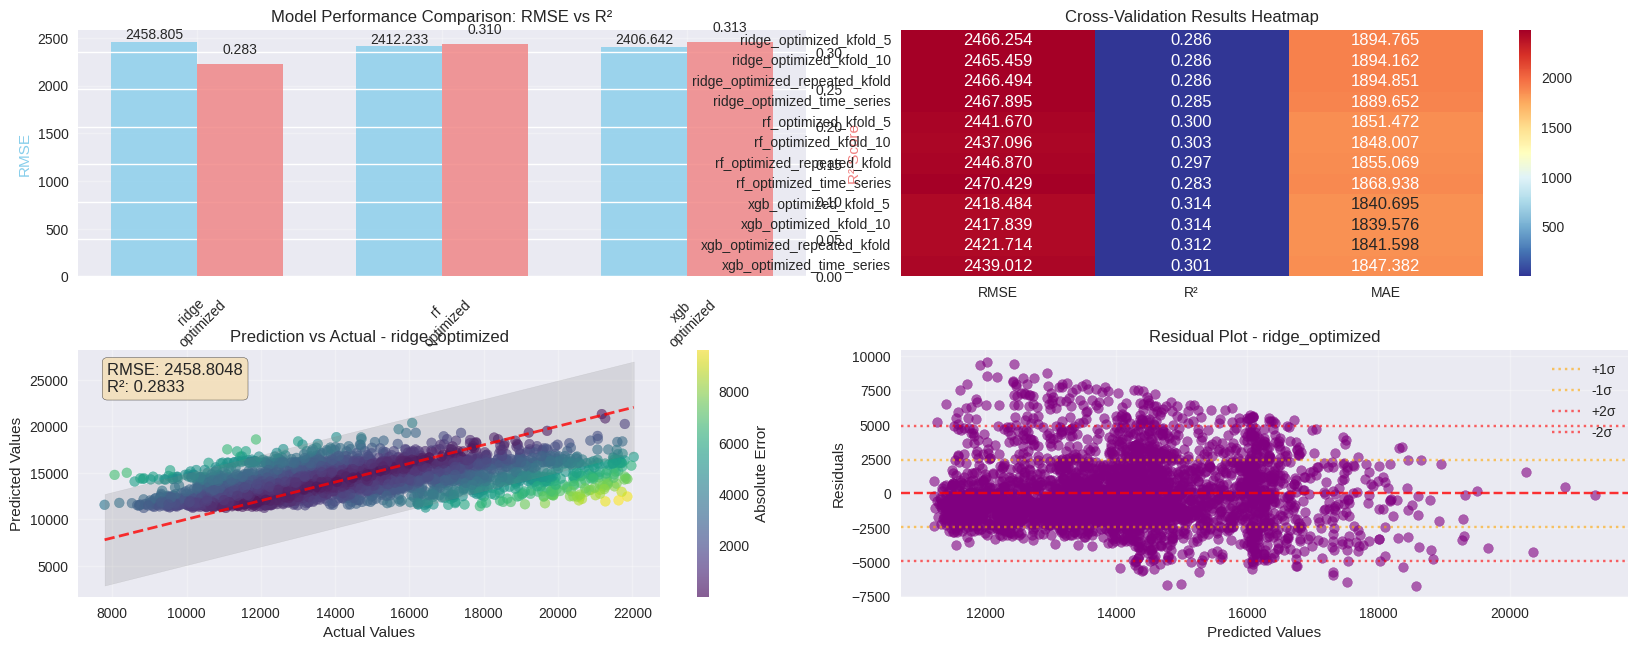

In [40]:
print("Creating comprehensive visualizations and final report...")

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 12

fig = plt.figure(figsize=(20, 24))
gs = GridSpec(6, 4, hspace=0.3, wspace=0.3)

ax1 = fig.add_subplot(gs[0, :2])
model_names = list(final_metrics.keys())
rmse_scores = [final_metrics[name]['test_rmse'] for name in model_names]
r2_scores = [final_metrics[name]['test_r2'] for name in model_names]

x_pos = np.arange(len(model_names))
width = 0.35

bars1 = ax1.bar(x_pos - width/2, rmse_scores, width, label='Test RMSE', alpha=0.8, color='skyblue')
ax1_twin = ax1.twinx()
bars2 = ax1_twin.bar(x_pos + width/2, r2_scores, width, label='Test R²', alpha=0.8, color='lightcoral')

ax1.set_xlabel('Models')
ax1.set_ylabel('RMSE', color='skyblue')
ax1_twin.set_ylabel('R² Score', color='lightcoral')
ax1.set_title('Model Performance Comparison: RMSE vs R²')
ax1.set_xticks(x_pos)
ax1.set_xticklabels([name.replace('_', '\n') for name in model_names], rotation=45)
ax1.grid(True, alpha=0.3)

for bar, value in zip(bars1, rmse_scores):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.3f}', ha='center', va='bottom', fontsize=10)

for bar, value in zip(bars2, r2_scores):
    ax1_twin.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                  f'{value:.3f}', ha='center', va='bottom', fontsize=10)

ax2 = fig.add_subplot(gs[0, 2:])
cv_data = []
cv_labels = []
for model_name, cv_dict in cv_results.items():
    for cv_name, results in cv_dict.items():
        if results:
            cv_data.append([results['test_rmse'], results['test_r2'], results['test_mae']])
            cv_labels.append(f"{model_name}_{cv_name}")

if cv_data:
    cv_df = pd.DataFrame(cv_data, columns=['RMSE', 'R²', 'MAE'], index=cv_labels)
    sns.heatmap(cv_df, annot=True, fmt='.3f', cmap='RdYlBu_r', ax=ax2)
    ax2.set_title('Cross-Validation Results Heatmap')
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
    ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0)

ax3 = fig.add_subplot(gs[1, :2])
best_pred = final_predictions[best_model_name]['test']
scatter = ax3.scatter(y_test, best_pred, alpha=0.6, c=np.abs(y_test - best_pred),
                     cmap='viridis', s=50)
ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, alpha=0.8)

residuals = y_test - best_pred
residual_std = np.std(residuals)
ax3.fill_between([y_test.min(), y_test.max()],
                [y_test.min() - 2*residual_std, y_test.max() - 2*residual_std],
                [y_test.min() + 2*residual_std, y_test.max() + 2*residual_std],
                alpha=0.2, color='gray', label='±2σ')

ax3.set_xlabel('Actual Values')
ax3.set_ylabel('Predicted Values')
ax3.set_title(f'Prediction vs Actual - {best_model_name}')
ax3.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax3, label='Absolute Error')

rmse_best = final_metrics[best_model_name]['test_rmse']
r2_best = final_metrics[best_model_name]['test_r2']
ax3.text(0.05, 0.95, f'RMSE: {rmse_best:.4f}\nR²: {r2_best:.4f}',
         transform=ax3.transAxes, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

ax4 = fig.add_subplot(gs[1, 2:])
residuals = y_test - best_pred
ax4.scatter(best_pred, residuals, alpha=0.6, color='purple')
ax4.axhline(y=0, color='red', linestyle='--', alpha=0.8)
ax4.axhline(y=residual_std, color='orange', linestyle=':', alpha=0.6, label='+1σ')
ax4.axhline(y=-residual_std, color='orange', linestyle=':', alpha=0.6, label='-1σ')
ax4.axhline(y=2*residual_std, color='red', linestyle=':', alpha=0.6, label='+2σ')
ax4.axhline(y=-2*residual_std, color='red', linestyle=':', alpha=0.6, label='-2σ')

ax4.set_xlabel('Predicted Values')
ax4.set_ylabel('Residuals')
ax4.set_title(f'Residual Plot - {best_model_name}')
ax4.grid(True, alpha=0.3)
ax4.legend()